# Create .h5 database step by step (sword)

## Table of contents
1. [Create filenames list to load](#create)
2. [Try to load single file: Markers and Analogs data](#single)
    - [Analogs (EMG)](#emg)
    - [Markers (marker, GRF, angles, forces, moment, power)](#marker)
3. [Attempt to connect  Analogs and Markers data sets](#connect)
4. [Big function to create 3D](#data)
    - [X vector](#x)
5. [Create.h5 file with only x vector](#xh5)
    - [Y vector](#y)
5. [Testing unload data](#testing)
6. [Create .h5 database](#h5)


#### 1. Create filenames list to load   <a name="create"></a>

In [17]:
input_folder = r'Z:\kk_database'

In [18]:
import glob

In [19]:
def get_filenames_form_path(input_folder):
    
    files_list = glob.glob(f'{input_folder}\\*.c3d', recursive=True)
    print("Load filenames:", len(files_list), "- we expect 15 person * 5 moves * 10 times = 3 750 filenames")
    
    return files_list

files_list = get_filenames_form_path(input_folder)

Load filenames: 3809 - we expect 15 person * 5 moves * 10 times = 3 750 filenames


In [20]:
def match_filenames(files_list):
    matchers_1 = ['T01','T02','T03','T04','T05']
    matchers_2 = ['K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'K10']

    interesting_filenames = [s for s in files_list if any(xs in s for xs in matchers_1)]
    matching_filenames = [s for s in interesting_filenames if any(xs in s for xs in matchers_2)]

    missing = len(files_list) - len(matching_filenames)

    print("Successful loading, samples after validation of the repetitions:", len(interesting_filenames), "- so it's missing", missing, "samples" )
    
    return matching_filenames

In [21]:
filenames = match_filenames(files_list)
# filenames

Successful loading, samples after validation of the repetitions: 3680 - so it's missing 129 samples


#### 2. Try to load single file: Markers and Analogs data    <a name="single"></a>
- **Analogs (EMG)** <a name="emg"></a>

In [22]:
from pyomeca import Markers, Analogs

In [23]:
def read_analog_to_dataframe(filename, preprocesing = False, time_normalisation = False):
    muscles = ["Voltage.1","Voltage.2","Voltage.3","Voltage.4",
               "Voltage.5","Voltage.6","Voltage.7","Voltage.8",
               "Voltage.9","Voltage.10","Voltage.11","Voltage.12",
               "Voltage.13","Voltage.14","Voltage.15","Voltage.16"]
    
    emg = Analogs.from_c3d(filename, usecols=muscles)
    
    if preprocesing:
            emg = (
                emg.meca.band_pass(order=2, cutoff=[10, 425])
                .meca.center()
                .meca.abs()
                .meca.low_pass(order=4, cutoff=5, freq=emg.rate)
                .meca.normalize(ref=None, scale=1)
            )
    else:
        pass
    
    if time_normalisation: 
        emg = emg.meca.time_normalize(n_frames=time_normalisation)
    else:
        pass
        
    emg_dataframe = emg.meca.to_wide_dataframe()
    emg_dataframe = emg_dataframe[muscles]
    
    return emg_dataframe

In [24]:
emg_df = read_analog_to_dataframe(filenames[0])
emg_df

channel  Voltage.1  Voltage.2  Voltage.3  Voltage.4  Voltage.5  Voltage.6  \
time                                                                        
0.000     0.003903  -0.005006  -0.004863   0.005207  -0.003764  -0.008394   
0.001     0.001309  -0.010652  -0.008525  -0.006237  -0.005137  -0.013734   
0.002     0.003140  -0.008516  -0.006236  -0.004254  -0.005290  -0.010225   
0.003    -0.004336  -0.010652  -0.013561  -0.018292  -0.007426  -0.010377   
0.004    -0.009219  -0.008210  -0.010204  -0.028210  -0.006358  -0.010225   
...            ...        ...        ...        ...        ...        ...   
3.280    -0.023868  -0.007753  -0.002117  -0.012188  -0.003611  -0.007631   
3.281    -0.023410  -0.006379   0.003071   0.000782  -0.005900  -0.009767   
3.282    -0.023868  -0.007448   0.001546  -0.001660  -0.004527  -0.010530   
3.283    -0.026004  -0.011567  -0.002574  -0.004101  -0.005748  -0.011751   
3.284    -0.021274  -0.009431  -0.002422  -0.008068  -0.005443  -0.011598   

channel  Voltage.7  Voltage.8  Voltage.9  Voltage.10  Voltage.11  Voltage.12  \
time                                                                           
0.000    -0.018764  -0.008400  -0.004374   -0.010762    0.001699   -0.026604   
0.001    -0.023036  -0.008247  -0.028635   -0.011220    0.005667   -0.031029   
0.002    -0.025020  -0.002907  -0.021464   -0.007405    0.007040   -0.015465   
0.003    -0.026393  -0.010841  -0.009409   -0.007100   -0.001658   -0.002800   
0.004    -0.023494  -0.010231  -0.007273   -0.003285   -0.005625   -0.001579   
...            ...        ...        ...         ...         ...         ...   
3.280    -0.005641  -0.001534  -0.034739   -0.002827   -0.010813   -0.001121   
3.281    -0.002742  -0.000313  -0.031382   -0.004048   -0.003031   -0.022636   
3.282    -0.004116   0.002281  -0.025431   -0.005269    0.001089   -0.037437   
3.283    -0.008846   0.000450  -0.015513   -0.005574    0.002462   -0.021873   
3.284    -0.010829  -0.000923   0.000662   -0.004659    0.006430    0.036720   

channel  Voltage.13  Voltage.14  Voltage.15  Voltage.16  
time                                                     
0.000     -0.001003   -0.000471   -0.005223   -0.003836  
0.001     -0.005733   -0.002760   -0.005376   -0.006736  
0.002     -0.003139    0.001207    0.001796   -0.005820  
0.003     -0.003902   -0.000319    0.007594   -0.003684  
0.004     -0.001308    0.001665    0.014613   -0.002310  
...             ...         ...         ...         ...  
3.280     -0.004207   -0.004896   -0.010106    0.009439  
3.281     -0.006649   -0.002455   -0.005528    0.036294  
3.282     -0.005581   -0.003370   -0.005071    0.073068  
3.283     -0.004207   -0.003676   -0.001256    0.124185  
3.284      0.000828    0.000139    0.006984    0.152719  

[3285 rows x 16 columns]

In [25]:
emg_df = read_analog_to_dataframe(filenames[0], preprocesing = True)
emg_df

channel  Voltage.1  Voltage.2  Voltage.3  Voltage.4  Voltage.5  Voltage.6  \
time                                                                        
0.000     0.130209  -0.002841   0.039229   0.019872  -0.005555   0.004186   
0.001     0.134482  -0.002437   0.040732   0.021271  -0.004959   0.004688   
0.002     0.138768  -0.002032   0.042239   0.022666  -0.004362   0.005190   
0.003     0.143065  -0.001628   0.043748   0.024057  -0.003764   0.005691   
0.004     0.147372  -0.001224   0.045260   0.025444  -0.003164   0.006190   
...            ...        ...        ...        ...        ...        ...   
3.280     0.303972   0.017332   0.118498   0.122743   0.092152   0.041344   
3.281     0.303963   0.017331   0.118495   0.122743   0.092149   0.041345   
3.282     0.303956   0.017331   0.118492   0.122743   0.092147   0.041346   
3.283     0.303950   0.017331   0.118490   0.122743   0.092145   0.041346   
3.284     0.303946   0.017331   0.118488   0.122743   0.092144   0.041347   

channel  Voltage.7  Voltage.8  Voltage.9  Voltage.10  Voltage.11  Voltage.12  \
time                                                                           
0.000     0.007467   0.006612   0.038659    0.006921    0.005150    0.137743   
0.001     0.007938   0.005743   0.044993    0.007142    0.005747    0.139689   
0.002     0.008409   0.004878   0.051315    0.007363    0.006340    0.141630   
0.003     0.008877   0.004018   0.057623    0.007586    0.006931    0.143564   
0.004     0.009344   0.003165   0.063915    0.007809    0.007518    0.145492   
...            ...        ...        ...         ...         ...         ...   
3.280     0.048439   0.042135   0.372751    0.013873    0.036002    0.299654   
3.281     0.048438   0.042136   0.372751    0.013874    0.036003    0.299657   
3.282     0.048437   0.042137   0.372752    0.013874    0.036004    0.299660   
3.283     0.048436   0.042138   0.372752    0.013874    0.036004    0.299662   
3.284     0.048436   0.042138   0.372753    0.013874    0.036004    0.299664   

channel  Voltage.13  Voltage.14  Voltage.15  Voltage.16  
time                                                     
0.000      0.010068    0.019596    0.042196    0.032482  
0.001      0.010137    0.020496    0.045231    0.035132  
0.002      0.010200    0.021397    0.048265    0.037776  
0.003      0.010260    0.022296    0.051297    0.040414  
0.004      0.010316    0.023195    0.054327    0.043045  
...             ...         ...         ...         ...  
3.280      0.031056    0.047301    0.091909    0.172446  
3.281      0.031056    0.047302    0.091912    0.172454  
3.282      0.031056    0.047303    0.091914    0.172461  
3.283      0.031056    0.047303    0.091915    0.172466  
3.284      0.031057    0.047304    0.091916    0.172471  

[3285 rows x 16 columns]

In [26]:
emg_df = read_analog_to_dataframe(filenames[0], preprocesing = True, time_normalisation = 200)
emg_df

channel   Voltage.1  Voltage.2  Voltage.3  Voltage.4  Voltage.5  Voltage.6  \
time                                                                         
0.000000   0.130209  -0.002841   0.039229   0.019872  -0.005555   0.004186   
0.016503   0.201241   0.003736   0.064019   0.042193   0.004429   0.012272   
0.033005   0.268112   0.009784   0.086515   0.061725   0.014721   0.019497   
0.049508   0.324083   0.014955   0.103550   0.077350   0.025598   0.025512   
0.066010   0.365684   0.019108   0.113134   0.088884   0.037614   0.030447   
...             ...        ...        ...        ...        ...        ...   
3.217990   0.317741   0.018200   0.125802   0.123157   0.098964   0.038880   
3.234492   0.310629   0.017670   0.121605   0.122892   0.094942   0.040288   
3.250995   0.306161   0.017425   0.119414   0.122774   0.092948   0.041030   
3.267497   0.304316   0.017344   0.118630   0.122746   0.092263   0.041298   
3.284000   0.303946   0.017331   0.118488   0.122743   0.092144   0.041347   

channel   Voltage.7  Voltage.8  Voltage.9  Voltage.10  Voltage.11  Voltage.12  \
time                                                                            
0.000000   0.007467   0.006612   0.038659    0.006921    0.005150    0.137743   
0.016503   0.014918  -0.006486   0.140207    0.010618    0.014492    0.168569   
0.033005   0.021063  -0.012998   0.229023    0.014144    0.022229    0.193986   
0.049508   0.025251  -0.005828   0.297573    0.017104    0.027847    0.211257   
0.066010   0.027344   0.022264   0.342615    0.019238    0.031328    0.220200   
...             ...        ...        ...         ...         ...         ...   
3.217990   0.050994   0.041715   0.372242    0.013267    0.035567    0.292593   
3.234492   0.049543   0.041685   0.372183    0.013575    0.035636    0.296640   
3.250995   0.048771   0.041938   0.372532    0.013776    0.035853    0.298757   
3.267497   0.048488   0.042100   0.372720    0.013858    0.035977    0.299524   
3.284000   0.048436   0.042138   0.372753    0.013874    0.036004    0.299664   

channel   Voltage.13  Voltage.14  Voltage.15  Voltage.16  
time                                                      
0.000000    0.010068    0.019596    0.042196    0.032482  
0.016503    0.010736    0.034189    0.091508    0.074979  
0.033005    0.011117    0.047167    0.136147    0.112554  
0.049508    0.012984    0.057248    0.172712    0.142858  
0.066010    0.018886    0.063837    0.200135    0.165363  
...              ...         ...         ...         ...  
3.217990    0.030985    0.046137    0.088077    0.165195  
3.234492    0.030973    0.046681    0.090041    0.167858  
3.250995    0.031020    0.047085    0.091301    0.170677  
3.267497    0.031050    0.047266    0.091816    0.172136  
3.284000    0.031057    0.047304    0.091916    0.172471  

[200 rows x 16 columns]

- **Markers (marker, GRF, angles, forces, moment, power)** <a name="marker"></a>

In [27]:
c_markers = ["LSHO","LELB","LWRA",
           "RSHO","RELB","RWRA",
           "T10",
           "LASI","LKNE","LANK",
           "RASI","RKNE","RANK",
           
           "Miecz:Miecz1", "Miecz:Miecz2", "Miecz:Miecz3"]

c_platform = ["RGroundReactionMoment","RGroundReactionForce"]

c_angles = ["LHipAngles","LKneeAngles","LAnkleAngles",
          "RHipAngles","RKneeAngles","RAnkleAngles",
          "LShoulderAngles","LElbowAngles","LWristAngles",
          "RShoulderAngles","RElbowAngles","RWristAngles"]

c_forces = ["LHipForce","LKneeForce","LAnkleForce",
          "RHipForce","RKneeForce","RAnkleForce",
          "LShoulderForce","LElbowForce","LWristForce",
          "RShoulderForce","RElbowForce","RWristForce"]

c_moments = ["LHipMoment","LKneeMoment","LAnkleMoment",
                    "RHipMoment","RKneeMoment","RAnkleMoment",
                    "LShoulderMoment","LElbowMoment","LWristMoment",
                    "RShoulderMoment","RElbowMoment","RWristMoment",]

c_powers = ["LHipPower","LKneePower","LAnklePower",
                   "RHipPower","RKneePower","RAnklePower",
                   "LShoulderPower","LElbowPower","LWristPower",
                   "RShoulderPower","RElbowPower","RWristPower",]

actors = ["B0444","B0445","B0446","B0447","B0448",
          "B0449","B0450","B0451","B0452","B0453",
          "B0454","B0455","B0456","B0457","B0458"]

all_chanels = c_markers + c_platform + c_angles + c_forces + c_moments + c_powers
# all_chanels = c_markers

print("All channels give", len(all_chanels), " modalities (x,y,z), which gives", len(all_chanels)*3, "paramameters")

All channels give 66  modalities (x,y,z), which gives 198 paramameters


In [28]:
filename = files_list[25]

In [29]:
def get_actor_name_from_file(filename):
    actor_name = filename.split('\\')[-1].split('-')[3]
    
    return actor_name

actor = get_actor_name_from_file(filename)
print("Actor name forom file is:", actor)

Actor name forom file is: B0444


In [30]:
def get_channel_for_actor(actor_name):
    actor_channel = list()

    for name in all_chanels:
        actor_channel.append(actor_name + ":" + name)
    actor_channel[13] =c_markers[-3]
    actor_channel[14] =c_markers[-2]
    actor_channel[15] =c_markers[-1]
    
    return actor_channel

actor_channel = get_channel_for_actor(actors[0])
print("All channels give", len(actor_channel), " modalities (x,y,z), which gives", len(actor_channel)*3, "paramameters, with repair actor name:", actors[0])

All channels give 66  modalities (x,y,z), which gives 198 paramameters, with repair actor name: B0444


In [31]:
def prepare_column_sequence(actor_channels):
    column_sequence = list()

    for idx, val in enumerate(actor_channels):
        column_sequence.append("x_"+ val)
        column_sequence.append("y_"+ val)
        column_sequence.append("z_"+ val)

    return column_sequence

column_sequence = prepare_column_sequence(actor_channel)
print("Column sequence lenght:", len(column_sequence))

Column sequence lenght: 198


In [32]:
def read_markers_to_dataframe(filename, time_normalisation = False):
    actor_name = get_actor_name_from_file(filename)
#     print(actor_name)
    actor_channel = get_channel_for_actor(actor_name)
#     print(actor_channel)
    marker = Markers.from_c3d(filename, usecols=actor_channel)
    
    if time_normalisation: 
        marker = marker.meca.time_normalize(n_frames=time_normalisation)
    else:
        pass
    
    marker_df = marker.meca.to_wide_dataframe()
    column_sequence = prepare_column_sequence(actor_channel)
    marker_dataframe = marker_df[column_sequence]
        
    return marker_dataframe

In [33]:
marker_df = read_markers_to_dataframe(filename)
marker_df

x_B0444:LSHO  y_B0444:LSHO  z_B0444:LSHO  x_B0444:LELB  y_B0444:LELB  \
time                                                                          
0.000   -465.213837   -285.406281   1470.341064   -420.692657   -113.237457   
0.005   -464.613373   -285.658386   1470.321045   -420.245300   -113.585037   
0.010   -464.028656   -285.886353   1470.283081   -419.829224   -113.929756   
0.015   -463.459808   -286.089874   1470.228760   -419.444427   -114.270683   
0.020   -462.906982   -286.268738   1470.159668   -419.090668   -114.606674   
...             ...           ...           ...           ...           ...   
2.380   -453.929749   -317.434998   1446.792358   -401.887878   -115.359169   
2.385   -453.228546   -317.706940   1447.412476   -401.271057   -115.563805   
2.390   -452.554321   -317.934052   1448.020142   -400.692169   -115.723076   
2.395   -451.907043   -318.114624   1448.614258   -400.151428   -115.835968   
2.400   -451.286682   -318.247101   1449.193970   -399.648926   -115.902000   

       z_B0444:LELB  x_B0444:LWRA  y_B0444:LWRA  z_B0444:LWRA  x_B0444:RSHO  \
time                                                                          
0.000   1179.663818   -263.639160   -168.010635   1356.762451   -196.426056   
0.005   1179.561768   -263.055817   -168.110550   1356.619385   -195.835022   
0.010   1179.426147   -262.510620   -168.191605   1356.449707   -195.257004   
0.015   1179.258911   -262.001801   -168.256134   1356.253174   -194.692612   
0.020   1179.062012   -261.527252   -168.306519   1356.029297   -194.142517   
...             ...           ...           ...           ...           ...   
2.380   1186.561035   -243.306198   -172.329895   1362.246460   -186.554993   
2.385   1187.219971   -242.492538   -172.447708   1362.784668   -185.961548   
2.390   1187.858398   -241.712677   -172.515213   1363.297729   -185.393768   
2.395   1188.473755   -240.968857   -172.533737   1363.783325   -184.851898   
2.400   1189.063477   -240.263046   -172.504425   1364.239746   -184.336044   

       ...  z_B0444:LWristPower  x_B0444:RShoulderPower  \
time   ...                                                
0.000  ...            -0.000058                     0.0   
0.005  ...            -0.000056                     0.0   
0.010  ...            -0.000048                     0.0   
0.015  ...            -0.000036                     0.0   
0.020  ...            -0.000019                     0.0   
...    ...                  ...                     ...   
2.380  ...             0.000071                     0.0   
2.385  ...             0.000059                     0.0   
2.390  ...             0.000049                     0.0   
2.395  ...             0.000039                     0.0   
2.400  ...             0.000029                     0.0   

       y_B0444:RShoulderPower  z_B0444:RShoulderPower  x_B0444:RElbowPower  \
time                                                                         
0.000                     0.0               -0.001232                  0.0   
0.005                     0.0               -0.001621                  0.0   
0.010                     0.0               -0.002039                  0.0   
0.015                     0.0               -0.002486                  0.0   
0.020                     0.0               -0.002955                  0.0   
...                       ...                     ...                  ...   
2.380                     0.0                0.007135                  0.0   
2.385                     0.0                0.005784                  0.0   
2.390                     0.0                0.004410                  0.0   
2.395                     0.0                0.003020                  0.0   
2.400                     0.0                0.001622                  0.0   

       y_B0444:RElbowPower  z_B0444:RElbowPower  x_B0444:RWristPower  \
time                                                                   
0.000                  0

In [34]:
marker_df = read_markers_to_dataframe(filename, time_normalisation=200)
marker_df

x_B0444:LSHO  y_B0444:LSHO  z_B0444:LSHO  x_B0444:LELB  \
time                                                               
0.000000   -465.213837   -285.406281   1470.341064   -420.692657   
0.012060   -463.794256   -285.970216   1470.260697   -419.670664   
0.024121   -462.464817   -286.395545   1470.091863   -418.824504   
0.036181   -461.233439   -286.672374   1469.852877   -418.156453   
0.048241   -460.106721   -286.797611   1469.564584   -417.653843   
...                ...           ...           ...           ...   
2.351759   -458.399228   -315.151045   1443.123541   -406.065680   
2.363819   -456.386266   -316.268201   1444.714937   -404.141909   
2.375879   -454.529857   -317.175523   1446.271951   -402.427148   
2.387940   -452.832143   -317.840468   1447.769747   -400.930706   
2.400000   -451.286682   -318.247101   1449.193970   -399.648926   

          y_B0444:LELB  z_B0444:LELB  x_B0444:LWRA  y_B0444:LWRA  \
time                                                               
0.000000   -113.237457   1179.663818   -263.639160   -168.010635   
0.012060   -114.070239   1179.357236   -262.300956   -168.218195   
0.024121   -114.878503   1178.876907   -261.162575   -168.338183   
0.036181   -115.644570   1178.243074   -260.201785   -168.396044   
0.048241   -116.351878   1177.484749   -259.388869   -168.409273   
...                ...           ...           ...           ...   
2.351759   -113.437859   1182.590059   -248.433555   -170.624078   
2.363819   -114.402832   1184.321612   -246.145137   -171.577668   
2.375879   -115.154333   1186.003506   -244.002631   -172.190022   
2.387940   -115.657447   1187.595328   -242.034027   -172.487397   
2.400000   -115.902000   1189.063477   -240.263046   -172.504425   

          z_B0444:LWRA  x_B0444:RSHO  ...  z_B0444:LWristPower  \
time                                  ...                        
0.000000   1356.762451   -196.426056  ...            -0.000058   
0.012060   1356.368724   -195.024440  ...            -0.000043   
0.024121   1355.822060   -193.701496  ...            -0.000003   
0.036181   1355.113489   -192.469820  ...             0.000052   
0.048241   1354.254131   -191.337517  ...             0.000107   
...                ...           ...  ...                  ...   
2.351759   1358.892096   -190.368288  ...             0.000191   
2.363819   1360.366937   -188.648837  ...             0.000128   
2.375879   1361.784401   -187.064963  ...             0.000082   
2.387940   1363.086317   -185.627728  ...             0.000054   
2.400000   1364.239746   -184.336044  ...             0.000029   

          x_B0444:RShoulderPower  y_B0444:RShoulderPower  \
time                                                       
0.000000                     0.0                     0.0   
0.012060                     0.0                     0.0   
0.024121                     0.0                     0.0   
0.036181                     0.0                     0.0   
0.048241                     0.0                     0.0   
...                          ...                     ...   
2.351759                     0.0                     0.0   
2.363819                     0.0                     0.0   
2.375879                     0.0                     0.0   
2.387940                     0.0                     0.0   
2.400000                     0.0                     0.0   

          z_B0444:RShoulderPower  x_B0444:RElbowPower  y_B0444:RElbowPower  \
time                                                                         
0.000000               -0.001232                  0.0                  0.0   
0.012060               -0.002224                  0.0                  0.0   
0.024121               -0.003356                  0.0                  0.0   
0.036181               -0.004553                  0.0                  0.0   
0.048241               -0.005731                  0.0                  0.0   
...                          ...                  ... 

#### 3. Attempt to connect  Analogs and Markers data sets <a name="connect"></a>

In [35]:
input_folder = r'Z:\kk_database'

filenames = get_filenames_form_path(input_folder)
filepath = filenames[600]

print(filepath)
time_normalisation = 200

emg_df = read_analog_to_dataframe(filepath, preprocesing = True, time_normalisation = time_normalisation)
marker_df = read_markers_to_dataframe(filepath, time_normalisation)

Load filenames: 3809 - we expect 15 person * 5 moves * 10 times = 3 750 filenames
Z:\kk_database\2020-08-06-B0446-S01-E02-T05-K1.c3d


ValueError: 'B0446:RGroundReactionMoment' is not in list

In [36]:
emg_df = emg_df.reset_index().drop('time', axis=1)
marker_df = marker_df.reset_index().drop('time', axis=1)
full_data = marker_df.join(emg_df)
full_data

x_B0444:LSHO  y_B0444:LSHO  z_B0444:LSHO  x_B0444:LELB  y_B0444:LELB  \
0     -465.213837   -285.406281   1470.341064   -420.692657   -113.237457   
1     -463.794256   -285.970216   1470.260697   -419.670664   -114.070239   
2     -462.464817   -286.395545   1470.091863   -418.824504   -114.878503   
3     -461.233439   -286.672374   1469.852877   -418.156453   -115.644570   
4     -460.106721   -286.797611   1469.564584   -417.653843   -116.351878   
..            ...           ...           ...           ...           ...   
195   -458.399228   -315.151045   1443.123541   -406.065680   -113.437859   
196   -456.386266   -316.268201   1444.714937   -404.141909   -114.402832   
197   -454.529857   -317.175523   1446.271951   -402.427148   -115.154333   
198   -452.832143   -317.840468   1447.769747   -400.930706   -115.657447   
199   -451.286682   -318.247101   1449.193970   -399.648926   -115.902000   

     z_B0444:LELB  x_B0444:LWRA  y_B0444:LWRA  z_B0444:LWRA  x_B0444:RSHO  \
0     1179.663818   -263.639160   -168.010635   1356.762451   -196.426056   
1     1179.357236   -262.300956   -168.218195   1356.368724   -195.024440   
2     1178.876907   -261.162575   -168.338183   1355.822060   -193.701496   
3     1178.243074   -260.201785   -168.396044   1355.113489   -192.469820   
4     1177.484749   -259.388869   -168.409273   1354.254131   -191.337517   
..            ...           ...           ...           ...           ...   
195   1182.590059   -248.433555   -170.624078   1358.892096   -190.368288   
196   1184.321612   -246.145137   -171.577668   1360.366937   -188.648837   
197   1186.003506   -244.002631   -172.190022   1361.784401   -187.064963   
198   1187.595328   -242.034027   -172.487397   1363.086317   -185.627728   
199   1189.063477   -240.263046   -172.504425   1364.239746   -184.336044   

     ...  Voltage.7  Voltage.8  Voltage.9  Voltage.10  Voltage.11  Voltage.12  \
0    ...  -0.008093   0.340356   0.285931   -0.004195    0.032679    0.083616   
1    ...   0.006721   0.471480   0.374655    0.015537    0.074308    0.154025   
2    ...   0.020586   0.573827   0.455569    0.033160    0.114307    0.221638   
3    ...   0.032660   0.638934   0.522141    0.047976    0.151663    0.283376   
4    ...   0.042327   0.663679   0.569995    0.059787    0.186192    0.337064   
..   ...        ...        ...        ...         ...         ...         ...   
195  ...   0.074736   0.166274   0.441622    0.035390    0.132170    0.432131   
196  ...   0.075146   0.171380   0.441367    0.035688    0.133419    0.437517   
197  ...   0.075330   0.173779   0.441219    0.035842    0.133969    0.440293   
198  ...   0.075384   0.174606   0.441157    0.035901    0.134144    0.441329   
199  ...   0.075392   0.174769   0.441141    0.035913    0.134176    0.441547   

     Voltage.13  Voltage.14  Voltage.15  Voltage.16  
0      0.054282    0.080895    0.017438    0.000077  
1      0.074797    0.101839    0.029488    0.061355  
2      0.089728    0.120132    0.040421    0.112746  
3      0.098440    0.134440    0.049285    0.151606  
4      0.101602    0.144059    0.055391    0.176928  
..          ...         ...         ...         ...  
195    0.867378    0.198464    0.488546    0.063071  
196    0.877341    0.198379    0.496402    0.063561  
197    0.881295    0.198530    0.500041    0.063783  
198    0.882376    0.198659    0.501285    0.063854  
199    0.882529    0.198701    0.501531    0.063866  

[200 rows x 214 columns]

In [37]:
def read_all_to_dataframe(filepath, time_normalisation, preprocesing = True,):
    emg_df = read_analog_to_dataframe(filepath, preprocesing, time_normalisation)
    marker_df = read_markers_to_dataframe(filepath, time_normalisation)
    
    emg_df = emg_df.reset_index().drop('time', axis=1)
    marker_df = marker_df.reset_index().drop('time', axis=1)
    full_data = marker_df.join(emg_df)
    
    return full_data

In [38]:
input_folder = r'Z:\kk_database'
filenames = get_filenames_form_path(input_folder)
filepath = filenames[0]
time_normalisation = 200
filepath

Load filenames: 3809 - we expect 15 person * 5 moves * 10 times = 3 750 filenames


'Z:\\kk_database\\2020-08-05-B0444-S01-E01-T01-K1.c3d'

In [39]:
x_1 = read_all_to_dataframe(filepath, time_normalisation)

#### 4. Big function to create 3D <a name="data"></a>
- **X vector** <a name="x"></a>

In [40]:
input_folder = r'Z:\kk_database'
filenames = get_filenames_form_path(input_folder)
time_normalisation = 200

Load filenames: 3809 - we expect 15 person * 5 moves * 10 times = 3 750 filenames


In [41]:
# for file in [filenames[0], filenames[1]]:
#     x_1 = read_all_to_dataframe(filepath, time_normalisation)
#     print(x_1)

In [42]:
from tqdm import tqdm
import config as cfg

In [43]:
def load_group(filenames, time_normalisation = 425):
    
    loaded = []
    bad_files =[]
    
    for file in tqdm(filenames, desc="Loading: "):
        try:
            data = read_all_to_dataframe(file, time_normalisation)
            if data.shape == (time_normalisation,214):
                loaded.append(data)
        except:
            bad_files.append(file)
    print("Bad files:", len(bad_files))
    print(bad_files)
    return loaded

In [44]:
# file_test = filenames[599:630]
# file_test
file_test = filenames
file_test

['Z:\\kk_database\\2020-08-05-B0444-S01-E01-T01-K1.c3d',
 'Z:\\kk_database\\2020-08-05-B0444-S01-E01-T01-K10.c3d',
 'Z:\\kk_database\\2020-08-05-B0444-S01-E01-T01-K2.c3d',
 'Z:\\kk_database\\2020-08-05-B0444-S01-E01-T01-K3.c3d',
 'Z:\\kk_database\\2020-08-05-B0444-S01-E01-T01-K4.c3d',
 'Z:\\kk_database\\2020-08-05-B0444-S01-E01-T01-K5.c3d',
 'Z:\\kk_database\\2020-08-05-B0444-S01-E01-T01-K6.c3d',
 'Z:\\kk_database\\2020-08-05-B0444-S01-E01-T01-K7.c3d',
 'Z:\\kk_database\\2020-08-05-B0444-S01-E01-T01-K8.c3d',
 'Z:\\kk_database\\2020-08-05-B0444-S01-E01-T01-K9.c3d',
 'Z:\\kk_database\\2020-08-05-B0444-S01-E01-T02-K1.c3d',
 'Z:\\kk_database\\2020-08-05-B0444-S01-E01-T02-K10.c3d',
 'Z:\\kk_database\\2020-08-05-B0444-S01-E01-T02-K2.c3d',
 'Z:\\kk_database\\2020-08-05-B0444-S01-E01-T02-K3.c3d',
 'Z:\\kk_database\\2020-08-05-B0444-S01-E01-T02-K4.c3d',
 'Z:\\kk_database\\2020-08-05-B0444-S01-E01-T02-K5.c3d',
 'Z:\\kk_database\\2020-08-05-B0444-S01-E01-T02-K6.c3d',
 'Z:\\kk_database\\2020-08-05

In [36]:
loaded = load_group(file_test, time_normalisation=425)

Loading: 100%|██████████| 3809/3809 [25:29<00:00,  2.49it/s]

Bad files: 882
['Z:\\kk_database\\2020-08-05-B0444-S01-E01-T03-K7.c3d', 'Z:\\kk_database\\2020-08-05-B0444-S01-E01-T03-K9.c3d', 'Z:\\kk_database\\2020-08-05-B0444-S01-E01-T05-K4.c3d', 'Z:\\kk_database\\2020-08-05-B0444-S01-E02-T01-K2.c3d', 'Z:\\kk_database\\2020-08-05-B0444-S01-E03-T03-K6.c3d', 'Z:\\kk_database\\2020-08-05-B0444-S01-E03-T04-K7.c3d', 'Z:\\kk_database\\2020-08-05-B0444-S01-E03-T05-K4.c3d', 'Z:\\kk_database\\2020-08-05-B0444-S01-E04-T05-K6.c3d', 'Z:\\kk_database\\2020-08-05-B0444-S01-E05-T01-K1.c3d', 'Z:\\kk_database\\2020-08-05-B0444-S01-E05-T01-K10.c3d', 'Z:\\kk_database\\2020-08-05-B0444-S01-E05-T01-K2.c3d', 'Z:\\kk_database\\2020-08-05-B0444-S01-E05-T01-K3.c3d', 'Z:\\kk_database\\2020-08-05-B0444-S01-E05-T01-K4.c3d', 'Z:\\kk_database\\2020-08-05-B0444-S01-E05-T01-K5.c3d', 'Z:\\kk_database\\2020-08-05-B0444-S01-E05-T01-K6.c3d', 'Z:\\kk_database\\2020-08-05-B0444-S01-E05-T01-K7.c3d', 'Z:\\kk_database\\2020-08-05-B0444-S01-E05-T01-K8.c3d', 'Z:\\kk_database\\2020-08-05-B0

In [37]:
loaded

[     x_B0444:LSHO  y_B0444:LSHO  z_B0444:LSHO  x_B0444:LELB  y_B0444:LELB  \
 0     -459.603394   -254.161926   1459.744751   -412.399506    -64.646652   
 1     -459.255280   -254.257506   1459.773974   -412.216241    -64.576353   
 2     -458.935146   -254.307993   1459.791702   -412.016858    -64.459743   
 3     -458.647338   -254.305935   1459.798764   -411.801335    -64.290719   
 4     -458.387664   -254.256936   1459.799001   -411.575074    -64.077775   
 ..            ...           ...           ...           ...           ...   
 420   -526.988399   -266.990920   1429.199364   -503.199442    -89.748401   
 421   -526.101949   -267.377797   1430.329903   -501.919675    -90.093439   
 422   -525.215300   -267.724682   1431.423317   -500.662393    -90.406190   
 423   -524.331560   -268.022407   1432.460797   -499.434769    -90.675245   
 424   -523.452881   -268.274567   1433.440308   -498.235352    -90.902046   
 
      z_B0444:LELB  x_B0444:LWRA  y_B0444:LWRA  z_B0444:LWRA  

In [45]:
import numpy as np
x = np.stack(loaded)
x.shape

NameError: name 'loaded' is not defined

# Wektor X i Y w jednej petli

In [46]:
from tqdm import tqdm
import config as cfg
import pandas as pd

In [47]:
def load_group(filenames, time_normalisation = 425):
    
    loaded = []
    bad_files =[]
    body = []
    move = []
    
    for file in tqdm(filenames, desc="Loading: "):
        try:
            data = read_all_to_dataframe(file, time_normalisation)
            actor = get_actor_name_from_file(file)
            if data.shape == (time_normalisation,214):
                loaded.append(data)
                body.append((cfg.body).index(actor))
                move.append((cfg.move).index(file.split('-')[5]))
        except:
            bad_files.append(file)
    
    print("Bad files:", len(bad_files))
    print(bad_files)
    
    y = pd.DataFrame({'Osoba': pd.Series(body),
                      'Ruch' : pd.Series(move)})
    return loaded,y

In [ ]:
loaded = load_group(filenames)

Loading:   9%|▉         | 346/3809 [02:29<20:20,  2.84it/s]

In [48]:
import numpy as np

In [169]:
x = np.stack(loaded[0])
y_bm = loaded[1]

In [170]:
x.shape

(2927, 425, 214)

In [171]:
y_bm.shape

(2927, 2)

In [172]:
note = pd.read_excel('adnotacja.xls', usecols='A:Y',skiprows=1)

In [149]:
note

Osoba  Ruch  wysokosc jelca  pozycja sztychu  ustawienie stóp  \
0       0     0               1                1                1   
1       0     1               1                1                1   
2       0     2               1                1                1   
3       0     3               1                1                1   
4       0     4               1                1                1   
..    ...   ...             ...              ...              ...   
70     14     0               0                1                1   
71     14     1               0                1                1   
72     14     2               1                1                1   
73     14     3               0                1                1   
74     14     4               1                0                1   

    lokcie blisko siebie  ruch noga do poz. koncowej  \
0                      1                           1   
1                      1                           1   
2                      1                           1   
3                      1                           1   
4                      1                           1   
..                   ...                         ...   
70                     0                           1   
71                     1                           1   
72                     0                           1   
73                     0                           0   
74                     0                           1   

    wyprostoawnie w lokciach  wyrzut rak do przodu  \
0                          1                     1   
1                          1                     1   
2                          1                     1   
3                          1                     1   
4                          1                     1   
..                       ...                   ...   
70                         1                     1   
71                         1                     1   
72                         1                     1   
73                         1                     1   
74                         1                     1   

    uderzenie odpowiednim ostrzem  Ocena 1  Ocena 2  Ocena 3  
0                               1        1        1        1  
1                               1        1        1        1  
2                               1        1        1        1  
3                               1        1        1        1  
4                               1        1        1        1  
..                            ...      ...      ...      ...  
70                              1        0        1        1  
71                              0        0        1        1  
72                              0        1        1        0  
73                              0        1        1        1  
74                              1        1        0        1  

[75 rows x 13 columns]

In [173]:
y = pd.merge(y_bm,note,how='inner',on =['Osoba','Ruch'])

In [181]:
print(y_bm)

      Osoba  Ruch
0         0     0
1         0     0
2         0     0
3         0     0
4         0     0
...     ...   ...
2922     14     3
2923     14     3
2924     14     3
2925     14     3
2926     14     3

[2927 rows x 2 columns]


In [174]:
y_person= y[y.columns[0:1]]
y_person

y_move= y[y.columns[1:2]]
y_move

y_features = y[y.columns[2:]]
y_features

wysokosc jelca  pozycja sztychu  ustawienie stóp  lokcie blisko siebie  \
0                  1                1                1                     1   
1                  1                1                1                     1   
2                  1                1                1                     1   
3                  1                1                1                     1   
4                  1                1                1                     1   
...              ...              ...              ...                   ...   
2922               0                1                1                     0   
2923               0                1                1                     0   
2924               0                1                1                     0   
2925               0                1                1                     0   
2926               0                1                1                     0   

      ruch noga do poz. koncowej  wyprostoawnie w lokciach  \
0                              1                         1   
1                              1                         1   
2                              1                         1   
3                              1                         1   
4                              1                         1   
...                          ...                       ...   
2922                           0                         1   
2923                           0                         1   
2924                           0                         1   
2925                           0                         1   
2926                           0                         1   

      wyrzut rak do przodu  uderzenie odpowiednim ostrzem  Ocena 1  Ocena 2  \
0                        1                              1        1        1   
1                        1                              1        1        1   
2                        1                              1        1        1   
3                        1                              1        1        1   
4                        1                              1        1        1   
...                    ...                            ...      ...      ...   
2922                     1                              0        1        1   
2923                     1                              0        1        1   
2924                     1                              0        1        1   
2925                     1                              0        1        1   
2926                     1                              0        1        1   

      Ocena 3  
0           1  
1           1  
2           1  
3           1  
4           1  
...       ...  
2922        1  
2923        1  
2924        1  
2925        1  
2926        1  

[2927 rows x 11 columns]

In [49]:
def create_h5_basic(path, x, y_person,y_move, y_features):
    f = h5py.File(path, mode='w')
    f.create_dataset("x", data=x)
    f.create_dataset("y_person", data=y_person)
    f.create_dataset("y_move", data=y_move)
    f.create_dataset("y_features", data=y_features)

#     print('x=', len(x), 'y=', len(y))

    f.close()

In [176]:
create_h5_basic("x_y_full_test.h5", x, y_person,y_move, y_features)

In [50]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt

In [184]:
f=h5py.File(r'x_y_full_test.h5', 'r')

#### 5. Create.h5 file with only x vector <a name="xh5"></a>

In [138]:
import h5py

In [152]:
def create_h5_basic(path, x):
    f = h5py.File(path, mode='w')
    f.create_dataset("x", data=x)
    
    print('x=', len(x))
    f.close()

In [140]:
create_h5_basic("x_y_testing1.h5", x)

x= 59


**Odczytywanie**

In [141]:
import pandas as pd

In [142]:
f=h5py.File('x_y_testing.h5', 'r')

In [143]:
print(list(f.keys()))

['x']


In [44]:
x_loaded = f['x']

In [45]:
print('(samples, timesteps, features) -> ', x.shape)

(samples, timesteps, features) ->  (19, 425, 214)


\\\\172.16.10.4\\Praktyki2020\\kk_database\\2020-08-06-B0446-S01-E02-T05-K1.c3d -> x1

In [46]:
type(x_loaded[0])

numpy.ndarray

In [47]:
df = pd.DataFrame(x_loaded[0])

In [48]:
df

0           1            2           3           4            5   \
0   -474.829987 -232.768677  1427.969604 -409.455536  -29.606350  1169.068237   
1   -474.829106 -231.436022  1428.232422 -409.801404  -28.091486  1169.351011   
2   -474.861229 -230.069317  1428.468172 -410.195029  -26.533746  1169.607651   
3   -474.927146 -228.668730  1428.674501 -410.637570  -24.934339  1169.834194   
4   -475.027447 -227.234396  1428.849091 -411.130024  -23.294506  1170.027005   
..          ...         ...          ...         ...         ...          ...   
420 -647.822134 -145.574064  1478.260586 -741.272985 -149.643389  1126.425936   
421 -646.253318 -146.103730  1479.594180 -739.539276 -150.007734  1127.778719   
422 -644.680021 -146.647726  1480.931042 -737.794246 -150.344309  1129.133857   
423 -643.101931 -147.207145  1482.262243 -736.040197 -150.654264  1130.477787   
424 -641.518921 -147.782898  1483.578979 -734.278748 -150.938217  1131.797363   

             6           7            8           9   ...        54        55  \
0   -237.900696 -103.609879  1327.827881 -232.745621  ...  0.057147  0.038699   
1   -238.059444 -102.075077  1327.903218 -232.932669  ...  0.073454  0.041506   
2   -238.257157 -100.478844  1327.953568 -233.135101  ...  0.091151  0.044294   
3   -238.494660  -98.821776  1327.974289 -233.352397  ...  0.110098  0.046987   
4   -238.772517  -97.104396  1327.961016 -233.583927  ...  0.130124  0.049505   
..          ...         ...          ...         ...  ...       ...       ...   
420 -514.649033  -78.288717  1172.904523 -319.500236  ...  0.149736  0.194567   
421 -512.410165  -79.625431  1173.539132 -318.336457  ...  0.149476  0.195569   
422 -510.184936  -80.891342  1174.232354 -317.182855  ...  0.149337  0.196124   
423 -507.974693  -82.089879  1174.968015 -316.037565  ...  0.149273  0.196386   
424 -505.779541  -83.225273  1175.728271 -314.898590  ...  0.149250  0.196483   

           56        57        58        59        60        61        62  \
0    0.041977 -0.008776 -0.002399  0.008257 -0.009005 -0.016607 -0.011735   
1    0.064119 -0.006017  0.001148  0.044403  0.018499 -0.012055  0.002410   
2    0.087707 -0.003135  0.004629  0.079848  0.045946 -0.008668  0.015996   
3    0.112516 -0.000148  0.007987  0.114127  0.073062 -0.006368  0.028853   
4    0.138289  0.002923  0.011169  0.146811  0.099599 -0.004996  0.040837   
..        ...       ...       ...       ...       ...       ...       ...   
420  0.155272  0.014073  0.045232  0.078664  0.137617  0.171288  0.053469   
421  0.154726  0.014039  0.045209  0.078599  0.138273  0.171177  0.053445   
422  0.154428  0.014021  0.045197  0.078563  0.138644  0.171120  0.053430   
423  0.154289  0.014012  0.045191  0.078546  0.138821  0.171095  0.053422   
424  0.154239  0.014009  0.045189  0.078540  0.138888  0.171086  0.053419   

           63  
0    0.046491  
1    0.053718  
2    0.060460  
3    0.066517  
4    0.071697  
..        ...  
420  0.232313  
421  0.231805  
422  0.231524  
423  0.231391  
424  0.231342  

[425 rows x 64 columns]

In [49]:
x_1 = read_all_to_dataframe(r'\\172.16.10.4\\Praktyki2020\\kk_database\\2020-08-05-B0444-S01-E01-T01-K10.c3d', time_normalisation=425)

In [50]:
x_1

x_B0444:LSHO  y_B0444:LSHO  z_B0444:LSHO  x_B0444:LELB  y_B0444:LELB  \
0     -474.829987   -232.768677   1427.969604   -409.455536    -29.606350   
1     -474.829106   -231.436022   1428.232422   -409.801404    -28.091486   
2     -474.861229   -230.069317   1428.468172   -410.195029    -26.533746   
3     -474.927146   -228.668730   1428.674501   -410.637570    -24.934339   
4     -475.027447   -227.234396   1428.849091   -411.130024    -23.294506   
..            ...           ...           ...           ...           ...   
420   -647.822134   -145.574064   1478.260586   -741.272985   -149.643389   
421   -646.253318   -146.103730   1479.594180   -739.539276   -150.007734   
422   -644.680021   -146.647726   1480.931042   -737.794246   -150.344309   
423   -643.101931   -147.207145   1482.262243   -736.040197   -150.654264   
424   -641.518921   -147.782898   1483.578979   -734.278748   -150.938217   

     z_B0444:LELB  x_B0444:LWRA  y_B0444:LWRA  z_B0444:LWRA  x_B0444:RSHO  \
0     1169.068237   -237.900696   -103.609879   1327.827881   -232.745621   
1     1169.351011   -238.059444   -102.075077   1327.903218   -232.932669   
2     1169.607651   -238.257157   -100.478844   1327.953568   -233.135101   
3     1169.834194   -238.494660    -98.821776   1327.974289   -233.352397   
4     1170.027005   -238.772517    -97.104396   1327.961016   -233.583927   
..            ...           ...           ...           ...           ...   
420   1126.425936   -514.649033    -78.288717   1172.904523   -319.500236   
421   1127.778719   -512.410165    -79.625431   1173.539132   -318.336457   
422   1129.133857   -510.184936    -80.891342   1174.232354   -317.182855   
423   1130.477787   -507.974693    -82.089879   1174.968015   -316.037565   
424   1131.797363   -505.779541    -83.225273   1175.728271   -314.898590   

     ...  Voltage.7  Voltage.8  Voltage.9  Voltage.10  Voltage.11  Voltage.12  \
0    ...   0.057147   0.038699   0.041977   -0.008776   -0.002399    0.008257   
1    ...   0.073454   0.041506   0.064119   -0.006017    0.001148    0.044403   
2    ...   0.091151   0.044294   0.087707   -0.003135    0.004629    0.079848   
3    ...   0.110098   0.046987   0.112516   -0.000148    0.007987    0.114127   
4    ...   0.130124   0.049505   0.138289    0.002923    0.011169    0.146811   
..   ...        ...        ...        ...         ...         ...         ...   
420  ...   0.149736   0.194567   0.155272    0.014073    0.045232    0.078664   
421  ...   0.149476   0.195569   0.154726    0.014039    0.045209    0.078599   
422  ...   0.149337   0.196124   0.154428    0.014021    0.045197    0.078563   
423  ...   0.149273   0.196386   0.154289    0.014012    0.045191    0.078546   
424  ...   0.149250   0.196483   0.154239    0.014009    0.045189    0.078540   

     Voltage.13  Voltage.14  Voltage.15  Voltage.16  
0     -0.009005   -0.016607   -0.011735    0.046491  
1      0.018499   -0.012055    0.002410    0.053718  
2      0.045946   -0.008668    0.015996    0.060460  
3      0.073062   -0.006368    0.028853    0.066517  
4      0.099599   -0.004996    0.040837    0.071697  
..          ...         ...         ...         ...  
420    0.137617    0.171288    0.053469    0.232313  
421    0.138273    0.171177    0.053445    0.231805  
422    0.138644    0.171120    0.053430    0.231524  
423    0.138821    0.171095    0.053422    0.231391  
424    0.138888    0.171086    0.053419    0.231342  

[425 rows x 214 columns]

##### Y vector 

In [51]:
y_names = file_test

In [51]:
import config as cfg

In [53]:
b = []
m = []
for path in y_names:
    s = str(path).split('\\')[-1]
    body = s.split('-')[3]
    b.append(cfg.body.index(body))
    m.append((cfg.move).index(s.split('-')[5]))

In [54]:
import pandas as pd
d = {'Osoba' : pd.Series(b),
     'Ruch' : pd.Series(m)
        }

In [55]:
df = pd.DataFrame(d)

In [56]:
df

Osoba  Ruch
0       0     0
1       0     0
2       0     0
3       0     0
4       0     0
5       0     0
6       0     0
7       0     0
8       0     0
9       0     0
10      0     0
11      0     0
12      0     0
13      0     0
14      0     0
15      0     0
16      0     0
17      0     0
18      0     0

In [57]:
import pandas as pd
bla=pd.read_excel('adnotacja.xls', usecols='A:Y',skiprows=1)

In [58]:
y = pd.merge(df,bla,how='inner',on =['Osoba','Ruch'])
y

Osoba  Ruch  wysokosc jelca  pozycja sztychu  ustawienie stóp  \
0       0     0               1                1                1   
1       0     0               1                1                1   
2       0     0               1                1                1   
3       0     0               1                1                1   
4       0     0               1                1                1   
5       0     0               1                1                1   
6       0     0               1                1                1   
7       0     0               1                1                1   
8       0     0               1                1                1   
9       0     0               1                1                1   
10      0     0               1                1                1   
11      0     0               1                1                1   
12      0     0               1                1                1   
13      0     0               1                1                1   
14      0     0               1                1                1   
15      0     0               1                1                1   
16      0     0               1                1                1   
17      0     0               1                1                1   
18      0     0               1                1                1   

    lokcie blisko siebie  ruch noga do poz. koncowej  \
0                      1                           1   
1                      1                           1   
2                      1                           1   
3                      1                           1   
4                      1                           1   
5                      1                           1   
6                      1                           1   
7                      1                           1   
8                      1                           1   
9                      1                           1   
10                     1                           1   
11                     1                           1   
12                     1                           1   
13                     1                           1   
14                     1                           1   
15                     1                           1   
16                     1                           1   
17                     1                           1   
18                     1                           1   

    wyprostoawnie w lokciach  wyrzut rak do przodu  \
0                          1                     1   
1                          1                     1   
2                          1                     1   
3                          1                     1   
4                          1                     1   
5                          1                     1   
6                          1                     1   
7                          1                     1   
8                          1                     1   
9                          1                     1   
10                         1                     1   
11                         1                     1   
12                         1                     1   
13                         1                     1   
14                         1                     1   
15                         1                     1   
16                         1                     1   
17                         1                     1   
18                         1                     1   

    uderzenie odpowiednim ostrzem  Ocena 1  Ocena 2  Ocena 3  
0                               1        1        1        1  
1                               1        1        1        1  
2                               1        1        1        1  
3                               1        1        1        1  
4                               1        1        1        1  
5                               1        1 

In [59]:
y_person= y[y.columns[0:1]]
y_person

y_move= y[y.columns[1:2]]
y_move

y_features = y[y.columns[2:]]
y_features

wysokosc jelca  pozycja sztychu  ustawienie stóp  lokcie blisko siebie  \
0                1                1                1                     1   
1                1                1                1                     1   
2                1                1                1                     1   
3                1                1                1                     1   
4                1                1                1                     1   
5                1                1                1                     1   
6                1                1                1                     1   
7                1                1                1                     1   
8                1                1                1                     1   
9                1                1                1                     1   
10               1                1                1                     1   
11               1                1                1                     1   
12               1                1                1                     1   
13               1                1                1                     1   
14               1                1                1                     1   
15               1                1                1                     1   
16               1                1                1                     1   
17               1                1                1                     1   
18               1                1                1                     1   

    ruch noga do poz. koncowej  wyprostoawnie w lokciach  \
0                            1                         1   
1                            1                         1   
2                            1                         1   
3                            1                         1   
4                            1                         1   
5                            1                         1   
6                            1                         1   
7                            1                         1   
8                            1                         1   
9                            1                         1   
10                           1                         1   
11                           1                         1   
12                           1                         1   
13                           1                         1   
14                           1                         1   
15                           1                         1   
16                           1                         1   
17                           1                         1   
18                           1                         1   

    wyrzut rak do przodu  uderzenie odpowiednim ostrzem  Ocena 1  Ocena 2  \
0                      1                              1        1        1   
1                      1                              1        1        1   
2                      1                              1        1        1   
3                      1                              1        1        1   
4                      1                              1        1        1   
5                      1                              1        1        1   
6                      1                              1        1        1   
7                      1                              1        1        1   
8                      1                              1        1        1   
9                      1                              1        1        1   
10                     1                              1        1        1   
11                     1                              1        1        1   
12                     1                              1        1        1   
13                     1                              1        1        1   
14                     1                              1        1        1   
15        

In [60]:
def create_h5_basic(path, x, y_person,y_move, y_features):
    f = h5py.File(path, mode='w')
    f.create_dataset("x", data=x)
    f.create_dataset("y_person", data=y_person)
    f.create_dataset("y_move", data=y_move)
    f.create_dataset("y_features", data=y_features)

#     print('x=', len(x), 'y=', len(y))

    f.close()

In [61]:
create_h5_basic("dataset/kk_testing_2.h5", x, y_person,y_move, y_features)

In [62]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt

In [63]:
f=h5py.File(r'dataset/kk_testing_2.h5', 'r')

In [185]:
print(list(f.keys()))

['x', 'y_features', 'y_move', 'y_person']


In [186]:
x = f['x']
y_person = f['y_person']
y_move = f['y_move']
y_features = f['y_features']

In [187]:
print('(samples, timesteps, features) (samples,person, move, features) -> ', x.shape, y_person.shape, y_move.shape, y_features.shape)

(samples, timesteps, features) (samples,person, move, features) ->  (2927, 425, 214) (2927, 1) (2927, 1) (2927, 11)


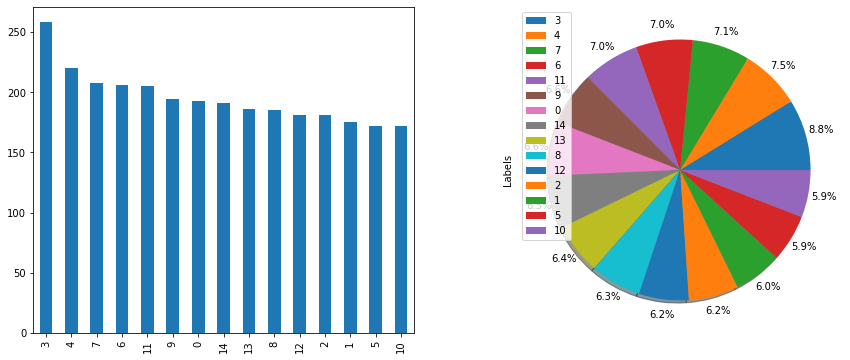

In [188]:
y = f['y_person']
fig, axs = plt.subplots(1,2)

y_df = pd.DataFrame(y)
y_df = y_df.rename(columns={0:'Labels'})
y_df_count = y_df['Labels'].value_counts()
y_df_count.plot.bar(ax=axs[0])
y_df_count.plot(kind='pie', figsize=(15, 6), autopct='%1.1f%%', shadow=True, labels=None, pctdistance=1.12, ax=axs[1])
plt.legend(labels=y_df_count.index, loc='upper left') 
plt.show()

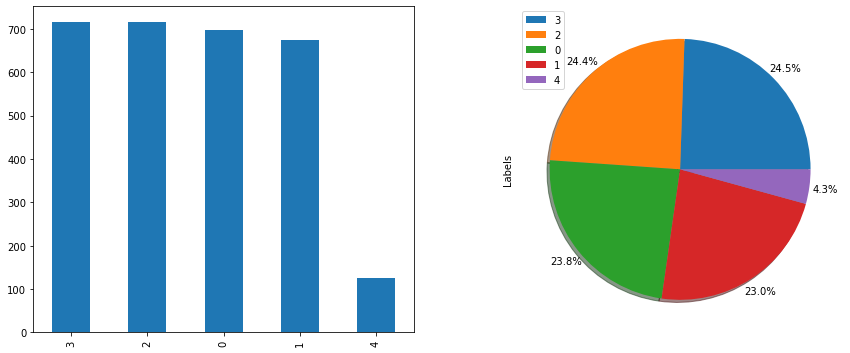

In [189]:
y = f['y_move']

fig, axs = plt.subplots(1,2)

y_df = pd.DataFrame(y)
y_df = y_df.rename(columns={0:'Labels'})
y_df_count = y_df['Labels'].value_counts()
y_df_count.plot.bar(ax=axs[0])
y_df_count.plot(kind='pie', figsize=(15, 6), autopct='%1.1f%%', shadow=True, labels=None, pctdistance=1.12, ax=axs[1])
plt.legend(labels=y_df_count.index, loc='upper left') 
plt.show()

#### 5. Testing unload data <a name="testing"></a>

In [69]:
file_ok = '2020-08-05-B0444-S01-E01-T01-K01.c3d'
file_bad = '2020-08-05-B0444-S01-E02-T04-K01.c3d'

In [70]:
def load_test(filename):
    
    print ("TEST: Analogs.from_c3d -", end =" ")
    try: emg = Analogs.from_c3d(filename, usecols=['Voltage.2']); print("ok")
    except: print("bad")
        
    print ("TEST: read_analog_to_dataframe -", end =" ")
    try: emg_df = read_analog_to_dataframe(filename); print("ok")
    except: print("bad")
        
    print ("TEST: get_actor_name_from_file -", end =" ")
    try: actor = get_actor_name_from_file(filename); print("ok")
    except: print("bad")
        
    print ("TEST: get_channel_for_actor -", end =" ")
    try: actor_channel = get_channel_for_actor(actor); print("ok")    
    except: print("bad")
    
    print ("TEST: Markers.from_c3d -", end =" ")
    try: marker = Markers.from_c3d(filename, usecols=actor_channel); print("ok")  
    except: print("bad")
        
    print ("TEST: prepare_column_sequence -", end =" ") 
    try: column_sequence = prepare_column_sequence(actor_channel); print("ok")    
    except: print("bad")
        
    print ("TEST: read_markers_to_dataframe -", end =" ")  
    try: marker_df = read_markers_to_dataframe(filename, time_normalisation=200); print("ok")    
    except: print("bad")
        
    print ("TEST: full_data -", end =" ")   
    try: full_data = marker_df.join(emg_df); print("ok")    
    except: print("bad")
        
    print ("TEST: read_all_to_dataframe -", end =" ")  
    try: x_1 = read_all_to_dataframe(filename, time_normalisation); print("ok")    
    except: print("bad")

In [71]:
file_ok = '2020-08-05-B0444-S01-E01-T01-K01.c3d'
file_bad = '2020-08-05-B0444-S01-E02-T04-K01.c3d'

In [72]:
load_test(file_ok)

TEST: Analogs.from_c3d - ok
TEST: read_analog_to_dataframe - ok
TEST: get_actor_name_from_file - ok
TEST: get_channel_for_actor - ok
TEST: Markers.from_c3d - ok
TEST: prepare_column_sequence - ok
TEST: read_markers_to_dataframe - ok
TEST: full_data - ok
TEST: read_all_to_dataframe - ok


In [73]:
load_test(file_bad)

TEST: Analogs.from_c3d - bad
TEST: read_analog_to_dataframe - bad
TEST: get_actor_name_from_file - ok
TEST: get_channel_for_actor - ok
TEST: Markers.from_c3d - bad
TEST: prepare_column_sequence - ok
TEST: read_markers_to_dataframe - bad
TEST: full_data - bad
TEST: read_all_to_dataframe - bad


#### 7. Lekko zmieniony podział plików

In [81]:
def cropp_c3dfile(eventsFrame, filename, destiny):
    reader = btk.btkAcquisitionFileReader()
    reader.SetFilename(filename)
    reader.Update()
    acq = reader.GetOutput()
 
    writer = btk.btkAcquisitionFileWriter()
    
    for i in range(0, len(eventsFrame)-1):
        clone = acq.Clone();
        clone.ResizeFrameNumberFromEnd(acq.GetLastFrame() - eventsFrame[i][0] + 1)
        clone.ResizeFrameNumber(eventsFrame[i][1] - eventsFrame[i][0] + 1)
        clone.SetFirstFrame(eventsFrame[i][0])
        clone.ClearEvents()
        for e in btk.Iterate(acq.GetEvents()):
            if ((e.GetFrame() > clone.GetFirstFrame()) and (e.GetFrame() < clone.GetLastFrame())):
                  clone.AppendEvent(e)
        clone.SetFirstFrame(1)
        writer.SetInput(clone)
        if i > 8:
            writer.SetFilename(destiny + '\\' + (filename.split('\\')[-1]).split('.')[0]+ '-K' + str(i+1) + '.c3d')
            writer.Update()
        else:
            writer.SetFilename(destiny + '\\' + (filename.split('\\')[-1]).split('.')[0]+ '-K0' + str(i+1) + '.c3d')
            writer.Update()

```python
importlib.reload(dp)
destiny = r'C:\Users\Grafika Multimedia\Desktop\Miecze_Praktyki\baza'
for path in Path(r'C:\Users\Grafika Multimedia\Desktop\Miecze_Praktyki').rglob('*.c3d'):
    czas = dp.read_labels(str(path),200)
    temp = []
    for i in range(len(czas[0])):
        if czas[0][i] != 0 and czas[1][i] != 0:
            temp.append([int(czas[0][i]), int(czas[1][i])])  
    dp.cropp_c3dfile(temp, str(path), str(destiny))
```

In [82]:
def read_labels(data_path,frame_rate):  
    c3d_to_compare= c3d(data_path)
    event = c3d_to_compare['parameters']['EVENT']['LABELS']['value']
    czas = np.around(c3d_to_compare['parameters']['EVENT']['TIMES']['value'][1]*frame_rate)
    eventy = [event, czas]
    
    eventy[0].index('Foot Strike')
    indxE = [i for i, x in enumerate(eventy[0]) if x == "Event"]
    indxFS = [i for i, x in enumerate(eventy[0]) if x == "Foot Strike"]

    CzasFS = np.zeros(len(indxFS))
    for i in range(len(indxFS)):
        CzasFS[i] = eventy[1][indxFS[i]]

    CzasE = np.zeros(len(indxE))
    for i in range(len(indxE)):
        CzasE[i] = eventy[1][indxE[i]]
    eventy[1].sort()

    p = []
    k = []
    for i in range(len(eventy[1])):
        if not i >= len(eventy[1])-2:
            pierwszy = eventy[1][i]
            drugi = eventy[1][i+1]
            trzeci = eventy[1][i+2]
            if pierwszy in CzasE:
                if drugi in CzasFS:
                    if trzeci in CzasE:
                        p.append(int(pierwszy))
                        k.append(int(trzeci))
    return [p,k]

In [83]:
import time
from pathlib import Path
from ezc3d import c3d
import numpy as np
from tqdm import tqdm

In [85]:
def data_base():
    b = []
    j = 0
    destiny = r'Z:\testing'
    for path in (Path(r'Z:\Miecz').rglob('*.c3d')):
        czas = read_labels(str(path),200)
        temp = []
        print(path)
        b.append(get_actor_name_from_file(str(path))) 
        for i in range(len(czas[0])):
            if czas[0][i] != 0 and czas[1][i] != 0:
                temp.append([int(czas[0][i]), int(czas[1][i])])  
        if j > 1:
            if b[i] == b[i-1]:
                print(b[i],b[i-1])
                cropp_c3dfile(temp, str(path), str(destiny))
            else:
                time.sleep(5)
                cropp_c3dfile(temp, str(path), str(destiny))
        j+=1

In [86]:
data_base()

Z:\Miecz\B0444\2020-08-05-B0444-S01\2020-08-05-B0444-S01-E01-T01.c3d
Z:\Miecz\B0444\2020-08-05-B0444-S01\2020-08-05-B0444-S01-E01-T02.c3d
Z:\Miecz\B0444\2020-08-05-B0444-S01\2020-08-05-B0444-S01-E01-T03.c3d


IndexError: list index out of range

In [76]:
from ezc3d import c3d
test_file = "2020-08-05-B0444-S01-E02-T04.c3d"
temp = read_labels(test_file, 200)

In [ ]:
import btk

In [78]:
cropp_c3dfile(temp, test_file, r"C:\Users\Konrad\Experiments2020\PhD Jupyter notebooks")

In [79]:
files = ["2020-08-05-B0444-S01-E02-T04-K1.c3d",
        "2020-08-05-B0444-S01-E02-T04-K2.c3d",
        "2020-08-05-B0444-S01-E02-T04-K3.c3d",
        "2020-08-05-B0444-S01-E02-T04-K4.c3d",
        "2020-08-05-B0444-S01-E02-T04-K5.c3d",
        "2020-08-05-B0444-S01-E02-T04-K6.c3d",
        "2020-08-05-B0444-S01-E02-T04-K7.c3d",
        "2020-08-05-B0444-S01-E02-T04-K8.c3d",
        "2020-08-05-B0444-S01-E02-T04-K9.c3d",
        "2020-08-05-B0444-S01-E02-T04-K10.c3d"]

for f in files:
    print ("\n =============================")
    print(f, "testing")
    load_test(f)


2020-08-05-B0444-S01-E02-T04-K1.c3d testing
TEST: Analogs.from_c3d - ok
TEST: read_analog_to_dataframe - ok
TEST: get_actor_name_from_file - ok
TEST: get_channel_for_actor - ok
TEST: Markers.from_c3d - ok
TEST: prepare_column_sequence - ok
TEST: read_markers_to_dataframe - ok
TEST: full_data - ok
TEST: read_all_to_dataframe - ok

2020-08-05-B0444-S01-E02-T04-K2.c3d testing
TEST: Analogs.from_c3d - ok
TEST: read_analog_to_dataframe - ok
TEST: get_actor_name_from_file - ok
TEST: get_channel_for_actor - ok
TEST: Markers.from_c3d - ok
TEST: prepare_column_sequence - ok
TEST: read_markers_to_dataframe - ok
TEST: full_data - ok
TEST: read_all_to_dataframe - ok

2020-08-05-B0444-S01-E02-T04-K3.c3d testing
TEST: Analogs.from_c3d - bad
TEST: read_analog_to_dataframe - bad
TEST: get_actor_name_from_file - ok
TEST: get_channel_for_actor - ok
TEST: Markers.from_c3d - bad
TEST: prepare_column_sequence - ok
TEST: read_markers_to_dataframe - bad
TEST: full_data - bad
TEST: read_all_to_dataframe - ba

In [80]:
emg = Analogs.from_c3d("2020-08-05-B0444-S01-E02-T04-K2.c3d", usecols=['Voltage.2'])

#### 7. Testing GRF and Moments

a. Which file don'tcontain GRF or angles.

In [81]:
c_platform = ["RGroundReactionMoment","RGroundReactionForce"]

c_angles = ["LHipAngles","LKneeAngles","LAnkleAngles",
          "RHipAngles","RKneeAngles","RAnkleAngles",
          "LShoulderAngles","LElbowAngles","LWristAngles",
          "RShoulderAngles","RElbowAngles","RWristAngles"]
all_chanels = c_markers + c_platform + c_angles 

In [191]:
def check_files(filepath):
    filenames = get_filenames_form_path(filepath)
    
    bad_files =[]
    
    for file in tqdm(filenames, desc="Loading: "):
        try: marker_df = read_markers_to_dataframe(file, time_normalisation)
        except:
            bad_files.append(file)
            print(file)
            
    return bad_files

In [ ]:
grf_lost = check_files(r"Z:\kk_database")

Loading:   0%|          | 0/3809 [00:00<?, ?it/s]

Load filenames: 3809 - we expect 15 person * 5 moves * 10 times = 3 750 filenames


Loading:   1%|          | 28/3809 [00:08<17:14,  3.66it/s]

Z:\kk_database\2020-08-05-B0444-S01-E01-T03-K7.c3d


Loading:   1%|          | 30/3809 [00:09<16:56,  3.72it/s]

Z:\kk_database\2020-08-05-B0444-S01-E01-T03-K9.c3d


Loading:   1%|          | 45/3809 [00:13<20:55,  3.00it/s]

Z:\kk_database\2020-08-05-B0444-S01-E01-T05-K4.c3d


Loading:   1%|▏         | 54/3809 [00:17<21:02,  2.97it/s]

Z:\kk_database\2020-08-05-B0444-S01-E02-T01-K2.c3d


Loading:   3%|▎         | 128/3809 [00:40<17:34,  3.49it/s]

Z:\kk_database\2020-08-05-B0444-S01-E03-T03-K6.c3d


Loading:   4%|▎         | 139/3809 [00:42<15:00,  4.08it/s]

Z:\kk_database\2020-08-05-B0444-S01-E03-T04-K7.c3d


Loading:   4%|▍         | 146/3809 [00:44<15:48,  3.86it/s]

Z:\kk_database\2020-08-05-B0444-S01-E03-T05-K4.c3d


Loading:   5%|▌         | 198/3809 [01:00<17:25,  3.46it/s]

Z:\kk_database\2020-08-05-B0444-S01-E04-T05-K6.c3d


Loading:   5%|▌         | 202/3809 [01:01<17:38,  3.41it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T01-K1.c3d


Loading:   5%|▌         | 204/3809 [01:01<16:37,  3.61it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T01-K10.c3d
Z:\kk_database\2020-08-05-B0444-S01-E05-T01-K2.c3d


Loading:   5%|▌         | 207/3809 [01:02<14:49,  4.05it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T01-K3.c3d
Z:\kk_database\2020-08-05-B0444-S01-E05-T01-K4.c3d
Z:\kk_database\2020-08-05-B0444-S01-E05-T01-K5.c3d


Loading:   5%|▌         | 208/3809 [01:02<15:23,  3.90it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T01-K6.c3d
Z:\kk_database\2020-08-05-B0444-S01-E05-T01-K7.c3d

Loading:   5%|▌         | 209/3809 [01:03<14:30,  4.14it/s]

Loading:   6%|▌         | 210/3809 [01:03<14:12,  4.22it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T01-K8.c3d


Loading:   6%|▌         | 211/3809 [01:03<14:06,  4.25it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T01-K9.c3d


Loading:   6%|▌         | 214/3809 [01:04<15:43,  3.81it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T02-K1.c3d
Z:\kk_database\2020-08-05-B0444-S01-E05-T02-K10.c3d
Z:\kk_database\2020-08-05-B0444-S01-E05-T02-K2.c3d


Loading:   6%|▌         | 215/3809 [01:04<14:40,  4.08it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T02-K3.c3d


Loading:   6%|▌         | 216/3809 [01:04<13:59,  4.28it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T02-K4.c3d


Loading:   6%|▌         | 217/3809 [01:05<13:19,  4.49it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T02-K5.c3d


Loading:   6%|▌         | 218/3809 [01:05<14:32,  4.12it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T02-K6.c3d
Z:\kk_database\2020-08-05-B0444-S01-E05-T02-K7.c3d


Loading:   6%|▌         | 220/3809 [01:05<13:23,  4.47it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T02-K8.c3d


Loading:   6%|▌         | 221/3809 [01:05<13:09,  4.55it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T02-K9.c3d


Loading:   6%|▌         | 222/3809 [01:06<16:03,  3.72it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T03-K1.c3d
Z:\kk_database\2020-08-05-B0444-S01-E05-T03-K10.c3d


Loading:   6%|▌         | 224/3809 [01:06<14:28,  4.13it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T03-K11.c3d


Loading:   6%|▌         | 225/3809 [01:06<13:23,  4.46it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T03-K2.c3d


Loading:   6%|▌         | 226/3809 [01:07<13:03,  4.57it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T03-K3.c3d


Loading:   6%|▌         | 228/3809 [01:07<13:52,  4.30it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T03-K4.c3d
Z:\kk_database\2020-08-05-B0444-S01-E05-T03-K5.c3d


Loading:   6%|▌         | 230/3809 [01:08<13:20,  4.47it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T03-K6.c3d
Z:\kk_database\2020-08-05-B0444-S01-E05-T03-K7.c3d


Loading:   6%|▌         | 231/3809 [01:08<13:16,  4.49it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T03-K8.c3d


Loading:   6%|▌         | 233/3809 [01:08<13:28,  4.42it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T03-K9.c3d
Z:\kk_database\2020-08-05-B0444-S01-E05-T04-K1.c3d


Loading:   6%|▌         | 236/3809 [01:09<09:00,  6.61it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T04-K10.c3d
Z:\kk_database\2020-08-05-B0444-S01-E05-T04-K2.c3d
Z:\kk_database\2020-08-05-B0444-S01-E05-T04-K3.c3d


Loading:   6%|▋         | 240/3809 [01:09<08:18,  7.16it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T04-K4.c3d
Z:\kk_database\2020-08-05-B0444-S01-E05-T04-K5.c3d
Z:\kk_database\2020-08-05-B0444-S01-E05-T04-K6.c3d
Z:\kk_database\2020-08-05-B0444-S01-E05-T04-K7.c3d


Loading:   6%|▋         | 243/3809 [01:10<11:02,  5.38it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T04-K8.c3d
Z:\kk_database\2020-08-05-B0444-S01-E05-T04-K9.c3d
Z:\kk_database\2020-08-05-B0444-S01-E05-T05-K1.c3d


Loading:   6%|▋         | 244/3809 [01:10<11:47,  5.04it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T05-K10.c3d


Loading:   6%|▋         | 245/3809 [01:10<12:20,  4.81it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T05-K2.c3d


Loading:   6%|▋         | 246/3809 [01:10<12:54,  4.60it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T05-K3.c3d


Loading:   6%|▋         | 247/3809 [01:11<12:28,  4.76it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T05-K4.c3d


Loading:   7%|▋         | 249/3809 [01:11<13:47,  4.30it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T05-K5.c3d
Z:\kk_database\2020-08-05-B0444-S01-E05-T05-K6.c3d


Loading:   7%|▋         | 250/3809 [01:11<13:13,  4.48it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T05-K7.c3d


Loading:   7%|▋         | 252/3809 [01:12<13:49,  4.29it/s]

Z:\kk_database\2020-08-05-B0444-S01-E05-T05-K8.c3d
Z:\kk_database\2020-08-05-B0444-S01-E05-T05-K9.c3d


Loading:   7%|▋         | 259/3809 [01:14<14:57,  3.95it/s]

Z:\kk_database\2020-08-06-B0445-S01-E01-T01-K7.c3d


Loading:   7%|▋         | 264/3809 [01:15<17:33,  3.36it/s]

Z:\kk_database\2020-08-06-B0445-S01-E01-T02-K3.c3d


Loading:   7%|▋         | 274/3809 [01:18<14:41,  4.01it/s]

Z:\kk_database\2020-08-06-B0445-S01-E01-T03-K3.c3d


Loading:   8%|▊         | 287/3809 [01:21<15:26,  3.80it/s]

Z:\kk_database\2020-08-06-B0445-S01-E01-T04-K6.c3d


Loading:   9%|▊         | 325/3809 [01:31<14:35,  3.98it/s]

Z:\kk_database\2020-08-06-B0445-S01-E02-T03-K4.c3d


Loading:   9%|▊         | 327/3809 [01:31<14:31,  3.99it/s]

Z:\kk_database\2020-08-06-B0445-S01-E02-T03-K6.c3d


Loading:   9%|▊         | 332/3809 [01:32<10:49,  5.36it/s]

Z:\kk_database\2020-08-06-B0445-S01-E02-T04-K1.c3d
Z:\kk_database\2020-08-06-B0445-S01-E02-T04-K10.c3d


Loading:   9%|▉         | 335/3809 [01:33<08:06,  7.13it/s]

Z:\kk_database\2020-08-06-B0445-S01-E02-T04-K2.c3d
Z:\kk_database\2020-08-06-B0445-S01-E02-T04-K3.c3d
Z:\kk_database\2020-08-06-B0445-S01-E02-T04-K4.c3d


Loading:   9%|▉         | 337/3809 [01:33<07:30,  7.71it/s]

Z:\kk_database\2020-08-06-B0445-S01-E02-T04-K5.c3d
Z:\kk_database\2020-08-06-B0445-S01-E02-T04-K6.c3d


Loading:   9%|▉         | 340/3809 [01:33<07:14,  7.98it/s]

Z:\kk_database\2020-08-06-B0445-S01-E02-T04-K7.c3d
Z:\kk_database\2020-08-06-B0445-S01-E02-T04-K8.c3d
Z:\kk_database\2020-08-06-B0445-S01-E02-T04-K9.c3d


Loading:   9%|▉         | 343/3809 [01:34<11:53,  4.86it/s]

Z:\kk_database\2020-08-06-B0445-S01-E02-T05-K2.c3d


Loading:   9%|▉         | 344/3809 [01:34<12:35,  4.58it/s]

Z:\kk_database\2020-08-06-B0445-S01-E02-T05-K3.c3d


Loading:   9%|▉         | 348/3809 [01:35<13:38,  4.23it/s]

Z:\kk_database\2020-08-06-B0445-S01-E02-T05-K7.c3d


Loading:  10%|█         | 399/3809 [02:58<19:56,  2.85it/s]  

Z:\kk_database\2020-08-06-B0445-S01-E03-T05-K7.c3d


Loading:  11%|█         | 400/3809 [02:58<18:25,  3.08it/s]

Z:\kk_database\2020-08-06-B0445-S01-E03-T05-K8.c3d


Loading:  11%|█         | 421/3809 [03:04<16:06,  3.51it/s]

Z:\kk_database\2020-08-06-B0445-S01-E04-T03-K1.c3d


Loading:  12%|█▏        | 443/3809 [03:11<15:49,  3.55it/s]

Z:\kk_database\2020-08-06-B0445-S01-E04-T05-K2.c3d


Loading:  12%|█▏        | 451/3809 [03:13<16:24,  3.41it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T01-K1.c3d


Loading:  12%|█▏        | 453/3809 [03:13<14:45,  3.79it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T01-K10.c3d
Z:\kk_database\2020-08-06-B0445-S01-E05-T01-K2.c3d


Loading:  12%|█▏        | 455/3809 [03:14<16:09,  3.46it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T01-K3.c3d
Z:\kk_database\2020-08-06-B0445-S01-E05-T01-K4.c3d


Loading:  12%|█▏        | 457/3809 [03:15<14:27,  3.87it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T01-K5.c3d
Z:\kk_database\2020-08-06-B0445-S01-E05-T01-K6.c3d


Loading:  12%|█▏        | 458/3809 [03:15<13:59,  3.99it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T01-K7.c3d


Loading:  12%|█▏        | 460/3809 [03:15<13:53,  4.02it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T01-K8.c3d
Z:\kk_database\2020-08-06-B0445-S01-E05-T01-K9.c3d


Loading:  12%|█▏        | 462/3809 [03:16<16:56,  3.29it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T02-K1.c3d
Z:\kk_database\2020-08-06-B0445-S01-E05-T02-K10.c3d


Loading:  12%|█▏        | 463/3809 [03:16<15:34,  3.58it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T02-K2.c3d


Loading:  12%|█▏        | 464/3809 [03:16<14:57,  3.72it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T02-K3.c3d


Loading:  12%|█▏        | 466/3809 [03:17<14:13,  3.92it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T02-K4.c3d
Z:\kk_database\2020-08-06-B0445-S01-E05-T02-K5.c3d


Loading:  12%|█▏        | 468/3809 [03:17<14:18,  3.89it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T02-K6.c3d
Z:\kk_database\2020-08-06-B0445-S01-E05-T02-K7.c3d


Loading:  12%|█▏        | 469/3809 [03:18<14:06,  3.95it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T02-K8.c3d


Loading:  12%|█▏        | 471/3809 [03:18<14:53,  3.74it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T02-K9.c3d
Z:\kk_database\2020-08-06-B0445-S01-E05-T03-K1.c3d


Loading:  12%|█▏        | 472/3809 [03:19<14:29,  3.84it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T03-K10.c3d


Loading:  12%|█▏        | 473/3809 [03:19<14:13,  3.91it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T03-K2.c3d


Loading:  12%|█▏        | 475/3809 [03:19<12:26,  4.47it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T03-K3.c3d
Z:\kk_database\2020-08-06-B0445-S01-E05-T03-K4.c3d


Loading:  13%|█▎        | 477/3809 [03:20<13:02,  4.26it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T03-K5.c3d
Z:\kk_database\2020-08-06-B0445-S01-E05-T03-K6.c3d


Loading:  13%|█▎        | 479/3809 [03:20<12:40,  4.38it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T03-K7.c3d
Z:\kk_database\2020-08-06-B0445-S01-E05-T03-K8.c3d


Loading:  13%|█▎        | 481/3809 [03:21<13:20,  4.16it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T03-K9.c3d
Z:\kk_database\2020-08-06-B0445-S01-E05-T04-K1.c3d


Loading:  13%|█▎        | 483/3809 [03:21<13:10,  4.21it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T04-K10.c3d
Z:\kk_database\2020-08-06-B0445-S01-E05-T04-K2.c3d


Loading:  13%|█▎        | 484/3809 [03:21<12:52,  4.31it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T04-K3.c3d


Loading:  13%|█▎        | 485/3809 [03:22<12:47,  4.33it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T04-K4.c3d


Loading:  13%|█▎        | 487/3809 [03:22<13:01,  4.25it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T04-K5.c3d
Z:\kk_database\2020-08-06-B0445-S01-E05-T04-K6.c3d


Loading:  13%|█▎        | 488/3809 [03:22<13:22,  4.14it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T04-K7.c3d


Loading:  13%|█▎        | 489/3809 [03:22<12:57,  4.27it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T04-K8.c3d


Loading:  13%|█▎        | 491/3809 [03:23<13:15,  4.17it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T04-K9.c3d
Z:\kk_database\2020-08-06-B0445-S01-E05-T05-K1.c3d


Loading:  13%|█▎        | 493/3809 [03:23<13:20,  4.14it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T05-K10.c3d
Z:\kk_database\2020-08-06-B0445-S01-E05-T05-K2.c3d


Loading:  13%|█▎        | 495/3809 [03:24<13:32,  4.08it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T05-K3.c3d
Z:\kk_database\2020-08-06-B0445-S01-E05-T05-K4.c3d


Loading:  13%|█▎        | 497/3809 [03:24<13:28,  4.10it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T05-K5.c3d
Z:\kk_database\2020-08-06-B0445-S01-E05-T05-K6.c3d


Loading:  13%|█▎        | 498/3809 [03:25<13:21,  4.13it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T05-K7.c3d


Loading:  13%|█▎        | 499/3809 [03:25<13:17,  4.15it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T05-K8.c3d


Loading:  13%|█▎        | 504/3809 [03:26<14:21,  3.84it/s]

Z:\kk_database\2020-08-06-B0445-S01-E05-T05-K9.c3d
Z:\kk_database\2020-08-06-B0446-S01-E01-T01-K3.c3d


Loading:  14%|█▍        | 535/3809 [03:35<14:22,  3.80it/s]

Z:\kk_database\2020-08-06-B0446-S01-E01-T04-K4.c3d


Loading:  15%|█▌        | 575/3809 [03:46<14:27,  3.73it/s]

Z:\kk_database\2020-08-06-B0446-S01-E02-T02-K4.c3d


Loading:  15%|█▌        | 579/3809 [03:47<14:21,  3.75it/s]

Z:\kk_database\2020-08-06-B0446-S01-E02-T02-K8.c3d


Loading:  15%|█▌        | 581/3809 [03:47<13:47,  3.90it/s]

Z:\kk_database\2020-08-06-B0446-S01-E02-T03-K1.c3d


Loading:  16%|█▌        | 601/3809 [03:52<12:06,  4.41it/s]

Z:\kk_database\2020-08-06-B0446-S01-E02-T05-K1.c3d
Z:\kk_database\2020-08-06-B0446-S01-E02-T05-K10.c3d


Loading:  16%|█▌        | 605/3809 [03:53<08:22,  6.38it/s]

Z:\kk_database\2020-08-06-B0446-S01-E02-T05-K2.c3d
Z:\kk_database\2020-08-06-B0446-S01-E02-T05-K3.c3d
Z:\kk_database\2020-08-06-B0446-S01-E02-T05-K4.c3d


Loading:  16%|█▌        | 608/3809 [03:53<07:12,  7.40it/s]

Z:\kk_database\2020-08-06-B0446-S01-E02-T05-K5.c3d
Z:\kk_database\2020-08-06-B0446-S01-E02-T05-K6.c3d
Z:\kk_database\2020-08-06-B0446-S01-E02-T05-K7.c3d


Loading:  16%|█▌        | 610/3809 [03:53<06:58,  7.64it/s]

Z:\kk_database\2020-08-06-B0446-S01-E02-T05-K8.c3d
Z:\kk_database\2020-08-06-B0446-S01-E02-T05-K9.c3d


Loading:  16%|█▌        | 614/3809 [03:54<12:13,  4.36it/s]

Z:\kk_database\2020-08-06-B0446-S01-E03-T01-K12.c3d


Loading:  16%|█▋        | 621/3809 [03:56<14:10,  3.75it/s]

Z:\kk_database\2020-08-06-B0446-S01-E03-T01-K8.c3d


Loading:  17%|█▋        | 632/3809 [03:59<13:33,  3.91it/s]

Z:\kk_database\2020-08-06-B0446-S01-E03-T02-K9.c3d


Loading:  17%|█▋        | 660/3809 [04:07<14:08,  3.71it/s]

Z:\kk_database\2020-08-06-B0446-S01-E03-T05-K7.c3d


Loading:  18%|█▊        | 670/3809 [04:09<13:22,  3.91it/s]

Z:\kk_database\2020-08-06-B0446-S01-E04-T01-K7.c3d


Loading:  18%|█▊        | 675/3809 [04:11<13:10,  3.97it/s]

Z:\kk_database\2020-08-06-B0446-S01-E04-T02-K2.c3d


Loading:  19%|█▊        | 706/3809 [04:18<08:38,  5.98it/s]

Z:\kk_database\2020-08-06-B0446-S01-E04-T05-K1.c3d
Z:\kk_database\2020-08-06-B0446-S01-E04-T05-K10.c3d
Z:\kk_database\2020-08-06-B0446-S01-E04-T05-K2.c3d
Z:\kk_database\2020-08-06-B0446-S01-E04-T05-K3.c3d


Loading:  19%|█▊        | 708/3809 [04:18<07:27,  6.93it/s]

Z:\kk_database\2020-08-06-B0446-S01-E04-T05-K4.c3d
Z:\kk_database\2020-08-06-B0446-S01-E04-T05-K5.c3d
Z:\kk_database\2020-08-06-B0446-S01-E04-T05-K6.c3d


Loading:  19%|█▊        | 710/3809 [04:18<06:39,  7.75it/s]

Z:\kk_database\2020-08-06-B0446-S01-E04-T05-K7.c3d
Z:\kk_database\2020-08-06-B0446-S01-E04-T05-K8.c3d
Z:\kk_database\2020-08-06-B0446-S01-E04-T05-K9.c3d


Loading:  19%|█▊        | 713/3809 [04:19<08:53,  5.80it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T01-K1.c3d


Loading:  19%|█▊        | 714/3809 [04:19<09:20,  5.52it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T01-K10.c3d


Loading:  19%|█▉        | 716/3809 [04:20<10:38,  4.84it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T01-K2.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T01-K3.c3d


Loading:  19%|█▉        | 717/3809 [04:20<13:12,  3.90it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T01-K4.c3d


Loading:  19%|█▉        | 718/3809 [04:20<13:08,  3.92it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T01-K5.c3d


Loading:  19%|█▉        | 719/3809 [04:20<12:48,  4.02it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T01-K6.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T01-K7.c3d


Loading:  19%|█▉        | 722/3809 [04:21<11:29,  4.48it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T01-K8.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T01-K9.c3d


Loading:  19%|█▉        | 725/3809 [04:22<10:55,  4.70it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T02-K1.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T02-K10.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T02-K2.c3d


Loading:  19%|█▉        | 726/3809 [04:22<11:00,  4.67it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T02-K3.c3d


Loading:  19%|█▉        | 728/3809 [04:22<11:15,  4.56it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T02-K4.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T02-K5.c3d


Loading:  19%|█▉        | 730/3809 [04:23<11:02,  4.65it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T02-K6.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T02-K7.c3d


Loading:  19%|█▉        | 732/3809 [04:23<10:54,  4.70it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T02-K8.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T02-K9.c3d


Loading:  19%|█▉        | 735/3809 [04:24<11:07,  4.60it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T03-K1.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T03-K10.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T03-K2.c3d


Loading:  19%|█▉        | 737/3809 [04:24<11:32,  4.43it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T03-K3.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T03-K4.c3d


Loading:  19%|█▉        | 738/3809 [04:25<11:21,  4.51it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T03-K5.c3d


Loading:  19%|█▉        | 740/3809 [04:25<11:31,  4.44it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T03-K6.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T03-K7.c3d


Loading:  19%|█▉        | 742/3809 [04:26<11:47,  4.34it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T03-K8.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T03-K9.c3d


Loading:  20%|█▉        | 744/3809 [04:26<11:26,  4.47it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T04-K1.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T04-K10.c3d


Loading:  20%|█▉        | 746/3809 [04:26<11:06,  4.60it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T04-K2.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T04-K3.c3d


Loading:  20%|█▉        | 747/3809 [04:27<11:02,  4.62it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T04-K4.c3d


Loading:  20%|█▉        | 748/3809 [04:27<11:21,  4.49it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T04-K5.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T04-K6.c3d


Loading:  20%|█▉        | 751/3809 [04:28<11:30,  4.43it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T04-K7.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T04-K8.c3d


Loading:  20%|█▉        | 754/3809 [04:28<10:14,  4.97it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T04-K9.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T05-K1.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T05-K10.c3d


Loading:  20%|█▉        | 757/3809 [04:29<10:18,  4.94it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T05-K2.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T05-K3.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T05-K4.c3d


Loading:  20%|█▉        | 759/3809 [04:29<10:06,  5.03it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T05-K5.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T05-K6.c3d


Loading:  20%|██        | 762/3809 [04:30<10:44,  4.72it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T05-K7.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T05-K8.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T05-K9.c3d


Loading:  20%|██        | 764/3809 [04:30<10:22,  4.89it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T06-K1.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T06-K10.c3d


Loading:  20%|██        | 765/3809 [04:30<10:08,  5.00it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T06-K2.c3d


Loading:  20%|██        | 766/3809 [04:31<10:23,  4.88it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T06-K3.c3d


Loading:  20%|██        | 769/3809 [04:31<10:01,  5.05it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T06-K4.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T06-K5.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T06-K6.c3d


Loading:  20%|██        | 771/3809 [04:32<10:54,  4.64it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T06-K7.c3d
Z:\kk_database\2020-08-06-B0446-S01-E05-T06-K8.c3d


Loading:  20%|██        | 772/3809 [04:32<10:34,  4.78it/s]

Z:\kk_database\2020-08-06-B0446-S01-E05-T06-K9.c3d


Loading:  21%|██        | 781/3809 [04:34<13:03,  3.87it/s]

Z:\kk_database\2020-08-07-B0447-S01-E01-T01-K8.c3d


Loading:  21%|██        | 799/3809 [04:41<17:02,  2.94it/s]

Z:\kk_database\2020-08-07-B0447-S01-E01-T03-K6.c3d


Loading:  21%|██        | 800/3809 [04:41<15:36,  3.21it/s]

Z:\kk_database\2020-08-07-B0447-S01-E01-T03-K7.c3d


Loading:  22%|██▏       | 833/3809 [04:50<11:01,  4.50it/s]

Z:\kk_database\2020-08-07-B0447-S01-E02-T02-K1.c3d
Z:\kk_database\2020-08-07-B0447-S01-E02-T02-K10.c3d
Z:\kk_database\2020-08-07-B0447-S01-E02-T02-K2.c3d

Loading:  22%|██▏       | 837/3809 [04:50<07:50,  6.32it/s]


Z:\kk_database\2020-08-07-B0447-S01-E02-T02-K3.c3d
Z:\kk_database\2020-08-07-B0447-S01-E02-T02-K4.c3d
Z:\kk_database\2020-08-07-B0447-S01-E02-T02-K5.c3d


Loading:  22%|██▏       | 841/3809 [04:50<05:57,  8.31it/s]

Z:\kk_database\2020-08-07-B0447-S01-E02-T02-K6.c3d
Z:\kk_database\2020-08-07-B0447-S01-E02-T02-K7.c3d
Z:\kk_database\2020-08-07-B0447-S01-E02-T02-K8.c3d
Z:\kk_database\2020-08-07-B0447-S01-E02-T02-K9.c3d


Loading:  23%|██▎       | 885/3809 [05:01<11:58,  4.07it/s]

Z:\kk_database\2020-08-07-B0447-S01-E03-T02-K2.c3d


Loading:  24%|██▎       | 901/3809 [05:05<12:54,  3.75it/s]

Z:\kk_database\2020-08-07-B0447-S01-E03-T03-K8.c3d


Loading:  24%|██▍       | 917/3809 [05:09<12:13,  3.94it/s]

Z:\kk_database\2020-08-07-B0447-S01-E03-T05-K4.c3d


Loading:  24%|██▍       | 921/3809 [05:10<11:41,  4.11it/s]

Z:\kk_database\2020-08-07-B0447-S01-E03-T05-K8.c3d


Loading:  24%|██▍       | 927/3809 [05:12<13:11,  3.64it/s]

Z:\kk_database\2020-08-07-B0447-S01-E04-T01-K4.c3d


Loading:  25%|██▍       | 939/3809 [05:15<12:26,  3.84it/s]

Z:\kk_database\2020-08-07-B0447-S01-E04-T02-K6.c3d


Loading:  25%|██▌       | 959/3809 [05:23<12:41,  3.74it/s]

Z:\kk_database\2020-08-07-B0447-S01-E04-T04-K6.c3d


Loading:  26%|██▋       | 1005/3809 [05:35<11:46,  3.97it/s]

Z:\kk_database\2020-08-07-B0447-S01-E05-T02-K2.c3d


Loading:  27%|██▋       | 1026/3809 [05:40<11:12,  4.14it/s]

Z:\kk_database\2020-08-07-B0447-S01-E05-T04-K3.c3d


Loading:  28%|██▊       | 1077/3809 [05:53<10:47,  4.22it/s]

Z:\kk_database\2020-08-07-B0448-S01-E01-T03-K4.c3d


Loading:  32%|███▏      | 1216/3809 [06:26<07:26,  5.81it/s]

Z:\kk_database\2020-08-07-B0448-S01-E04-T02-K1.c3d
Z:\kk_database\2020-08-07-B0448-S01-E04-T02-K10.c3d
Z:\kk_database\2020-08-07-B0448-S01-E04-T02-K2.c3d
Z:\kk_database\2020-08-07-B0448-S01-E04-T02-K3.c3d


Loading:  32%|███▏      | 1220/3809 [06:26<05:36,  7.69it/s]

Z:\kk_database\2020-08-07-B0448-S01-E04-T02-K4.c3d
Z:\kk_database\2020-08-07-B0448-S01-E04-T02-K5.c3d
Z:\kk_database\2020-08-07-B0448-S01-E04-T02-K6.c3d
Z:\kk_database\2020-08-07-B0448-S01-E04-T02-K7.c3d
Z:\kk_database\2020-08-07-B0448-S01-E04-T02-K8.c3d


Loading:  32%|███▏      | 1224/3809 [06:27<05:29,  7.85it/s]

Z:\kk_database\2020-08-07-B0448-S01-E04-T02-K9.c3d


Loading:  33%|███▎      | 1255/3809 [06:34<08:57,  4.75it/s]

Z:\kk_database\2020-08-07-B0448-S01-E05-T01-K1.c3d
Z:\kk_database\2020-08-07-B0448-S01-E05-T01-K10.c3d


Loading:  33%|███▎      | 1256/3809 [06:34<08:54,  4.78it/s]

Z:\kk_database\2020-08-07-B0448-S01-E05-T01-K2.c3d
Z:\kk_database\2020-08-07-B0448-S01-E05-T01-K3.c3d


Loading:  33%|███▎      | 1258/3809 [06:34<08:27,  5.02it/s]

Z:\kk_database\2020-08-07-B0448-S01-E05-T01-K4.c3d


Loading:  33%|███▎      | 1260/3809 [06:35<08:32,  4.98it/s]

Z:\kk_database\2020-08-07-B0448-S01-E05-T01-K5.c3d
Z:\kk_database\2020-08-07-B0448-S01-E05-T01-K6.c3d


Loading:  33%|███▎      | 1261/3809 [06:35<08:31,  4.98it/s]

Z:\kk_database\2020-08-07-B0448-S01-E05-T01-K7.c3d


Loading:  33%|███▎      | 1262/3809 [06:35<08:55,  4.75it/s]

Z:\kk_database\2020-08-07-B0448-S01-E05-T01-K8.c3d
Z:\kk_database\2020-08-07-B0448-S01-E05-T01-K9.c3d


Loading:  34%|███▍      | 1294/3809 [06:45<09:29,  4.42it/s]

Z:\kk_database\2020-08-07-B0448-S01-E05-T05-K1.c3d


Loading:  34%|███▍      | 1296/3809 [06:45<08:51,  4.73it/s]

Z:\kk_database\2020-08-07-B0448-S01-E05-T05-K10.c3d
Z:\kk_database\2020-08-07-B0448-S01-E05-T05-K2.c3d


Loading:  34%|███▍      | 1297/3809 [06:45<08:33,  4.89it/s]

Z:\kk_database\2020-08-07-B0448-S01-E05-T05-K3.c3d


Loading:  34%|███▍      | 1300/3809 [06:46<08:13,  5.08it/s]

Z:\kk_database\2020-08-07-B0448-S01-E05-T05-K4.c3d
Z:\kk_database\2020-08-07-B0448-S01-E05-T05-K5.c3d
Z:\kk_database\2020-08-07-B0448-S01-E05-T05-K6.c3d


Loading:  34%|███▍      | 1301/3809 [06:46<08:30,  4.91it/s]

Z:\kk_database\2020-08-07-B0448-S01-E05-T05-K7.c3d


Loading:  34%|███▍      | 1302/3809 [06:46<08:42,  4.80it/s]

Z:\kk_database\2020-08-07-B0448-S01-E05-T05-K8.c3d


Loading:  34%|███▍      | 1303/3809 [06:46<08:34,  4.87it/s]

Z:\kk_database\2020-08-07-B0448-S01-E05-T05-K9.c3d


Loading:  35%|███▍      | 1315/3809 [06:49<07:11,  5.78it/s]

Z:\kk_database\2020-08-07-B0449-S01-E01-T02-K1.c3d
Z:\kk_database\2020-08-07-B0449-S01-E01-T02-K10.c3d


Loading:  35%|███▍      | 1318/3809 [06:49<05:51,  7.09it/s]

Z:\kk_database\2020-08-07-B0449-S01-E01-T02-K2.c3d
Z:\kk_database\2020-08-07-B0449-S01-E01-T02-K3.c3d
Z:\kk_database\2020-08-07-B0449-S01-E01-T02-K4.c3d
Z:\kk_database\2020-08-07-B0449-S01-E01-T02-K5.c3d
Z:\kk_database\2020-08-07-B0449-S01-E01-T02-K6.c3d

Loading:  35%|███▍      | 1322/3809 [06:50<04:36,  8.99it/s]


Z:\kk_database\2020-08-07-B0449-S01-E01-T02-K7.c3d
Z:\kk_database\2020-08-07-B0449-S01-E01-T02-K8.c3d


Loading:  35%|███▍      | 1324/3809 [06:50<05:18,  7.79it/s]

Z:\kk_database\2020-08-07-B0449-S01-E01-T02-K9.c3d


Loading:  35%|███▌      | 1345/3809 [06:55<08:16,  4.97it/s]

Z:\kk_database\2020-08-07-B0449-S01-E01-T05-K1.c3d
Z:\kk_database\2020-08-07-B0449-S01-E01-T05-K10.c3d


Loading:  35%|███▌      | 1347/3809 [06:55<07:46,  5.28it/s]

Z:\kk_database\2020-08-07-B0449-S01-E01-T05-K2.c3d
Z:\kk_database\2020-08-07-B0449-S01-E01-T05-K3.c3d
Z:\kk_database\2020-08-07-B0449-S01-E01-T05-K4.c3d


Loading:  35%|███▌      | 1350/3809 [06:56<07:42,  5.32it/s]

Z:\kk_database\2020-08-07-B0449-S01-E01-T05-K5.c3d
Z:\kk_database\2020-08-07-B0449-S01-E01-T05-K6.c3d


Loading:  35%|███▌      | 1351/3809 [06:56<07:48,  5.25it/s]

Z:\kk_database\2020-08-07-B0449-S01-E01-T05-K7.c3d


Loading:  36%|███▌      | 1354/3809 [06:57<06:56,  5.90it/s]

Z:\kk_database\2020-08-07-B0449-S01-E01-T05-K8.c3d
Z:\kk_database\2020-08-07-B0449-S01-E01-T05-K9.c3d
Z:\kk_database\2020-08-07-B0449-S01-E01-T06-K1.c3d


Loading:  36%|███▌      | 1357/3809 [06:57<05:08,  7.95it/s]

Z:\kk_database\2020-08-07-B0449-S01-E01-T06-K10.c3d
Z:\kk_database\2020-08-07-B0449-S01-E01-T06-K2.c3d
Z:\kk_database\2020-08-07-B0449-S01-E01-T06-K3.c3d


Loading:  36%|███▌      | 1359/3809 [06:57<05:07,  7.97it/s]

Z:\kk_database\2020-08-07-B0449-S01-E01-T06-K4.c3d
Z:\kk_database\2020-08-07-B0449-S01-E01-T06-K5.c3d


Loading:  36%|███▌      | 1361/3809 [06:57<04:39,  8.75it/s]

Z:\kk_database\2020-08-07-B0449-S01-E01-T06-K6.c3d
Z:\kk_database\2020-08-07-B0449-S01-E01-T06-K7.c3d


Loading:  36%|███▌      | 1364/3809 [06:58<05:18,  7.69it/s]

Z:\kk_database\2020-08-07-B0449-S01-E01-T06-K8.c3d
Z:\kk_database\2020-08-07-B0449-S01-E01-T06-K9.c3d
Z:\kk_database\2020-08-07-B0449-S01-E02-T1-K1.c3d


Loading:  37%|███▋      | 1423/3809 [07:13<10:24,  3.82it/s]

Z:\kk_database\2020-08-07-B0449-S01-E03-T02-K10.c3d


Loading:  38%|███▊      | 1441/3809 [07:17<10:00,  3.94it/s]

Z:\kk_database\2020-08-07-B0449-S01-E03-T03-K9.c3d


Loading:  38%|███▊      | 1446/3809 [07:18<09:41,  4.06it/s]

Z:\kk_database\2020-08-07-B0449-S01-E03-T04-K4.c3d


Loading:  38%|███▊      | 1450/3809 [07:19<09:34,  4.11it/s]

Z:\kk_database\2020-08-07-B0449-S01-E03-T04-K8.c3d


Loading:  40%|███▉      | 1510/3809 [07:35<09:41,  3.95it/s]

Z:\kk_database\2020-08-07-B0449-S01-E04-T05-K8.c3d


Loading:  40%|███▉      | 1512/3809 [07:36<11:18,  3.39it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T01-K1.c3d


Loading:  40%|███▉      | 1514/3809 [07:36<09:21,  4.09it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T01-K10.c3d
Z:\kk_database\2020-08-07-B0449-S01-E05-T01-K2.c3d


Loading:  40%|███▉      | 1516/3809 [07:37<08:13,  4.65it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T01-K3.c3d
Z:\kk_database\2020-08-07-B0449-S01-E05-T01-K4.c3d


Loading:  40%|███▉      | 1517/3809 [07:37<08:10,  4.67it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T01-K5.c3d


Loading:  40%|███▉      | 1518/3809 [07:37<08:15,  4.62it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T01-K6.c3d


Loading:  40%|███▉      | 1519/3809 [07:37<08:21,  4.57it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T01-K7.c3d


Loading:  40%|███▉      | 1521/3809 [07:38<08:45,  4.36it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T01-K8.c3d
Z:\kk_database\2020-08-07-B0449-S01-E05-T01-K9.c3d


Loading:  40%|███▉      | 1522/3809 [07:38<08:39,  4.41it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T02-K1.c3d


Loading:  40%|███▉      | 1523/3809 [07:38<08:26,  4.51it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T02-K10.c3d


Loading:  40%|████      | 1524/3809 [07:38<08:21,  4.55it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T02-K2.c3d


Loading:  40%|████      | 1526/3809 [07:39<10:10,  3.74it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T02-K3.c3d
Z:\kk_database\2020-08-07-B0449-S01-E05-T02-K4.c3d


Loading:  40%|████      | 1527/3809 [07:39<09:24,  4.04it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T02-K5.c3d


Loading:  40%|████      | 1528/3809 [07:39<08:55,  4.26it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T02-K6.c3d
Z:\kk_database\2020-08-07-B0449-S01-E05-T02-K7.c3d


Loading:  40%|████      | 1530/3809 [07:40<08:04,  4.70it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T02-K8.c3d


Loading:  40%|████      | 1532/3809 [07:40<07:59,  4.75it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T02-K9.c3d
Z:\kk_database\2020-08-07-B0449-S01-E05-T03-K1.c3d
Z:\kk_database\2020-08-07-B0449-S01-E05-T03-K10.c3d


Loading:  40%|████      | 1535/3809 [07:41<07:34,  5.00it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T03-K2.c3d
Z:\kk_database\2020-08-07-B0449-S01-E05-T03-K3.c3d


Loading:  40%|████      | 1536/3809 [07:41<07:24,  5.11it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T03-K4.c3d
Z:\kk_database\2020-08-07-B0449-S01-E05-T03-K5.c3d

Loading:  40%|████      | 1538/3809 [07:41<07:35,  4.99it/s]


Z:\kk_database\2020-08-07-B0449-S01-E05-T03-K6.c3d


Loading:  40%|████      | 1540/3809 [07:42<07:22,  5.12it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T03-K7.c3d
Z:\kk_database\2020-08-07-B0449-S01-E05-T03-K8.c3d


Loading:  40%|████      | 1542/3809 [07:42<07:14,  5.22it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T03-K9.c3d
Z:\kk_database\2020-08-07-B0449-S01-E05-T04-K1.c3d


Loading:  41%|████      | 1544/3809 [07:43<07:15,  5.20it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T04-K10.c3d
Z:\kk_database\2020-08-07-B0449-S01-E05-T04-K2.c3d


Loading:  41%|████      | 1547/3809 [07:43<06:59,  5.39it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T04-K3.c3d
Z:\kk_database\2020-08-07-B0449-S01-E05-T04-K4.c3d
Z:\kk_database\2020-08-07-B0449-S01-E05-T04-K5.c3d


Loading:  41%|████      | 1549/3809 [07:43<07:07,  5.29it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T04-K6.c3d
Z:\kk_database\2020-08-07-B0449-S01-E05-T04-K7.c3d


Loading:  41%|████      | 1551/3809 [07:44<07:13,  5.21it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T04-K8.c3d
Z:\kk_database\2020-08-07-B0449-S01-E05-T04-K9.c3d


Loading:  41%|████      | 1552/3809 [07:44<07:12,  5.21it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T05-K1.c3d


Loading:  41%|████      | 1554/3809 [07:44<07:28,  5.03it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T05-K10.c3d
Z:\kk_database\2020-08-07-B0449-S01-E05-T05-K2.c3d


Loading:  41%|████      | 1555/3809 [07:45<07:22,  5.09it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T05-K3.c3d


Loading:  41%|████      | 1557/3809 [07:45<07:12,  5.20it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T05-K4.c3d
Z:\kk_database\2020-08-07-B0449-S01-E05-T05-K5.c3d


Loading:  41%|████      | 1559/3809 [07:45<07:13,  5.19it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T05-K6.c3d
Z:\kk_database\2020-08-07-B0449-S01-E05-T05-K7.c3d


Loading:  41%|████      | 1561/3809 [07:46<07:10,  5.22it/s]

Z:\kk_database\2020-08-07-B0449-S01-E05-T05-K8.c3d
Z:\kk_database\2020-08-07-B0449-S01-E05-T05-K9.c3d


Loading:  43%|████▎     | 1623/3809 [08:01<08:57,  4.06it/s]

Z:\kk_database\2020-08-10-B0450-S01-E02-T02-K10.c3d


Loading:  45%|████▌     | 1715/3809 [08:24<09:30,  3.67it/s]

Z:\kk_database\2020-08-10-B0450-S01-E04-T01-K3.c3d


Loading:  45%|████▌     | 1722/3809 [08:26<08:42,  4.00it/s]

Z:\kk_database\2020-08-10-B0450-S01-E04-T02-K1.c3d


Loading:  46%|████▋     | 1762/3809 [08:35<07:40,  4.44it/s]

Z:\kk_database\2020-08-10-B0450-S01-E04-T06-K1.c3d


Loading:  47%|████▋     | 1772/3809 [08:37<07:10,  4.73it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T01-K1.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T01-K10.c3d


Loading:  47%|████▋     | 1774/3809 [08:37<06:46,  5.01it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T01-K2.c3d


Loading:  47%|████▋     | 1776/3809 [08:38<06:42,  5.06it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T01-K3.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T01-K4.c3d


Loading:  47%|████▋     | 1777/3809 [08:38<06:45,  5.01it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T01-K5.c3d


Loading:  47%|████▋     | 1779/3809 [08:38<07:14,  4.67it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T01-K6.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T01-K7.c3d


Loading:  47%|████▋     | 1781/3809 [08:39<06:53,  4.90it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T01-K8.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T01-K9.c3d


Loading:  47%|████▋     | 1782/3809 [08:39<06:48,  4.96it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T02-K1.c3d


Loading:  47%|████▋     | 1785/3809 [08:40<06:31,  5.17it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T02-K10.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T02-K2.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T02-K3.c3d


Loading:  47%|████▋     | 1786/3809 [08:40<06:40,  5.05it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T02-K4.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T02-K5.c3d


Loading:  47%|████▋     | 1788/3809 [08:40<06:09,  5.47it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T02-K6.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T02-K7.c3d


Loading:  47%|████▋     | 1791/3809 [08:41<06:14,  5.39it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T02-K8.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T02-K9.c3d


Loading:  47%|████▋     | 1794/3809 [08:41<06:20,  5.29it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T03-K1.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T03-K10.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T03-K2.c3d


Loading:  47%|████▋     | 1797/3809 [08:42<06:06,  5.48it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T03-K3.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T03-K4.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T03-K5.c3d


Loading:  47%|████▋     | 1800/3809 [08:42<06:07,  5.47it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T03-K6.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T03-K7.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T03-K8.c3d


Loading:  47%|████▋     | 1801/3809 [08:43<06:31,  5.13it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T03-K9.c3d


Loading:  47%|████▋     | 1802/3809 [08:43<06:32,  5.11it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T04-K1.c3d


Loading:  47%|████▋     | 1804/3809 [08:43<07:05,  4.72it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T04-K10.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T04-K2.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T04-K3.c3d


Loading:  47%|████▋     | 1806/3809 [08:44<07:25,  4.49it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T04-K4.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T04-K5.c3d


Loading:  48%|████▊     | 1810/3809 [08:44<06:15,  5.32it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T04-K6.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T04-K7.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T04-K8.c3d


Loading:  48%|████▊     | 1811/3809 [08:45<06:10,  5.40it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T04-K9.c3d


Loading:  48%|████▊     | 1813/3809 [08:45<06:33,  5.07it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T05-K1.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T05-K10.c3d


Loading:  48%|████▊     | 1815/3809 [08:45<06:08,  5.40it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T05-K2.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T05-K3.c3d


Loading:  48%|████▊     | 1817/3809 [08:46<05:50,  5.69it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T05-K4.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T05-K5.c3d


Loading:  48%|████▊     | 1820/3809 [08:46<05:42,  5.81it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T05-K6.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T05-K7.c3d
Z:\kk_database\2020-08-10-B0450-S01-E05-T05-K8.c3d


Loading:  48%|████▊     | 1821/3809 [08:46<05:45,  5.75it/s]

Z:\kk_database\2020-08-10-B0450-S01-E05-T05-K9.c3d


Loading:  48%|████▊     | 1829/3809 [08:49<08:52,  3.72it/s]

Z:\kk_database\2020-08-12-B0451-S01-E01-T01-K7.c3d


Loading:  49%|████▉     | 1862/3809 [08:58<08:33,  3.79it/s]

Z:\kk_database\2020-08-12-B0451-S01-E01-T05-K1.c3d


Loading:  49%|████▉     | 1866/3809 [08:59<08:47,  3.68it/s]

Z:\kk_database\2020-08-12-B0451-S01-E01-T05-K4.c3d


Loading:  49%|████▉     | 1868/3809 [09:00<08:25,  3.84it/s]

Z:\kk_database\2020-08-12-B0451-S01-E01-T05-K6.c3d


Loading:  50%|████▉     | 1893/3809 [09:07<07:58,  4.01it/s]

Z:\kk_database\2020-08-12-B0451-S01-E02-T03-K10.c3d


Loading:  50%|████▉     | 1903/3809 [09:09<08:07,  3.91it/s]

Z:\kk_database\2020-08-12-B0451-S01-E02-T04-K10.c3d


Loading:  51%|█████     | 1937/3809 [09:18<07:51,  3.97it/s]

Z:\kk_database\2020-08-12-B0451-S01-E03-T02-K5.c3d


Loading:  51%|█████     | 1946/3809 [09:20<07:45,  4.00it/s]

Z:\kk_database\2020-08-12-B0451-S01-E03-T03-K4.c3d


Loading:  52%|█████▏    | 1996/3809 [09:33<07:35,  3.98it/s]

Z:\kk_database\2020-08-12-B0451-S01-E04-T03-K4.c3d


Loading:  53%|█████▎    | 2017/3809 [09:39<07:41,  3.88it/s]

Z:\kk_database\2020-08-12-B0451-S01-E04-T05-K5.c3d


Loading:  53%|█████▎    | 2031/3809 [09:43<07:31,  3.94it/s]

Z:\kk_database\2020-08-12-B0451-S01-E05-T01-K9.c3d
Z:\kk_database\2020-08-12-B0451-S01-E05-T02-K1.c3d


Loading:  53%|█████▎    | 2033/3809 [09:43<07:07,  4.16it/s]

Z:\kk_database\2020-08-12-B0451-S01-E05-T02-K10.c3d
Z:\kk_database\2020-08-12-B0451-S01-E05-T02-K2.c3d


Loading:  53%|█████▎    | 2036/3809 [09:44<06:29,  4.55it/s]

Z:\kk_database\2020-08-12-B0451-S01-E05-T02-K3.c3d
Z:\kk_database\2020-08-12-B0451-S01-E05-T02-K4.c3d


Loading:  53%|█████▎    | 2037/3809 [09:44<06:25,  4.60it/s]

Z:\kk_database\2020-08-12-B0451-S01-E05-T02-K5.c3d


Loading:  54%|█████▎    | 2039/3809 [09:45<06:31,  4.52it/s]

Z:\kk_database\2020-08-12-B0451-S01-E05-T02-K6.c3d
Z:\kk_database\2020-08-12-B0451-S01-E05-T02-K7.c3d


Loading:  54%|█████▎    | 2041/3809 [09:45<06:25,  4.59it/s]

Z:\kk_database\2020-08-12-B0451-S01-E05-T02-K8.c3d
Z:\kk_database\2020-08-12-B0451-S01-E05-T02-K9.c3d


Loading:  54%|█████▎    | 2042/3809 [09:45<06:22,  4.62it/s]

Z:\kk_database\2020-08-12-B0451-S01-E05-T03-K1.c3d


Loading:  54%|█████▎    | 2043/3809 [09:45<07:08,  4.12it/s]

Z:\kk_database\2020-08-12-B0451-S01-E05-T03-K10.c3d
Z:\kk_database\2020-08-12-B0451-S01-E05-T03-K2.c3d


Loading:  54%|█████▎    | 2045/3809 [09:46<06:34,  4.48it/s]

Z:\kk_database\2020-08-12-B0451-S01-E05-T03-K3.c3d


Loading:  54%|█████▎    | 2046/3809 [09:46<06:20,  4.63it/s]

Z:\kk_database\2020-08-12-B0451-S01-E05-T03-K4.c3d


Loading:  54%|█████▍    | 2048/3809 [09:47<06:16,  4.68it/s]

Z:\kk_database\2020-08-12-B0451-S01-E05-T03-K5.c3d
Z:\kk_database\2020-08-12-B0451-S01-E05-T03-K6.c3d


Loading:  54%|█████▍    | 2050/3809 [09:47<06:13,  4.71it/s]

Z:\kk_database\2020-08-12-B0451-S01-E05-T03-K7.c3d
Z:\kk_database\2020-08-12-B0451-S01-E05-T03-K8.c3d


Loading:  54%|█████▍    | 2051/3809 [09:47<06:04,  4.82it/s]

Z:\kk_database\2020-08-12-B0451-S01-E05-T03-K9.c3d


Loading:  54%|█████▍    | 2061/3809 [09:50<07:28,  3.90it/s]

Z:\kk_database\2020-08-12-B0451-S01-E05-T04-K9.c3d


Loading:  54%|█████▍    | 2063/3809 [09:50<07:26,  3.91it/s]

Z:\kk_database\2020-08-12-B0451-S01-E05-T05-K1.c3d
Z:\kk_database\2020-08-12-B0451-S01-E05-T05-K10.c3d


Loading:  54%|█████▍    | 2065/3809 [09:51<07:10,  4.05it/s]

Z:\kk_database\2020-08-12-B0451-S01-E05-T05-K2.c3d
Z:\kk_database\2020-08-12-B0451-S01-E05-T05-K3.c3d


Loading:  54%|█████▍    | 2066/3809 [09:51<06:54,  4.21it/s]

Z:\kk_database\2020-08-12-B0451-S01-E05-T05-K4.c3d


Loading:  54%|█████▍    | 2069/3809 [09:52<06:17,  4.61it/s]

Z:\kk_database\2020-08-12-B0451-S01-E05-T05-K5.c3d
Z:\kk_database\2020-08-12-B0451-S01-E05-T05-K6.c3d
Z:\kk_database\2020-08-12-B0451-S01-E05-T05-K7.c3d


Loading:  54%|█████▍    | 2070/3809 [09:52<07:18,  3.97it/s]

Z:\kk_database\2020-08-12-B0451-S01-E05-T05-K8.c3d


Loading:  57%|█████▋    | 2157/3809 [10:14<06:43,  4.10it/s]

Z:\kk_database\2020-08-12-B0451-S01-E05-T05-K9.c3d
Z:\kk_database\2020-08-12-B0452-S01-E02-T04-K5.c3d


Loading:  57%|█████▋    | 2180/3809 [10:20<07:18,  3.71it/s]

Z:\kk_database\2020-08-12-B0452-S01-E03-T01-K8.c3d


Loading:  57%|█████▋    | 2190/3809 [10:22<07:17,  3.70it/s]

Z:\kk_database\2020-08-12-B0452-S01-E03-T02-K8.c3d


Loading:  58%|█████▊    | 2204/3809 [10:26<06:53,  3.89it/s]

Z:\kk_database\2020-08-12-B0452-S01-E03-T04-K2.c3d


Loading:  58%|█████▊    | 2219/3809 [10:30<07:08,  3.71it/s]

Z:\kk_database\2020-08-12-B0452-S01-E03-T05-K7.c3d


Loading:  58%|█████▊    | 2222/3809 [10:31<07:38,  3.46it/s]

Z:\kk_database\2020-08-12-B0452-S01-E04-T01-K1.c3d


Loading:  58%|█████▊    | 2225/3809 [10:32<06:39,  3.96it/s]

Z:\kk_database\2020-08-12-B0452-S01-E04-T01-K10.c3d
Z:\kk_database\2020-08-12-B0452-S01-E04-T01-K2.c3d
Z:\kk_database\2020-08-12-B0452-S01-E04-T01-K3.c3d


Loading:  58%|█████▊    | 2226/3809 [10:32<06:54,  3.82it/s]

Z:\kk_database\2020-08-12-B0452-S01-E04-T01-K4.c3d


Loading:  58%|█████▊    | 2228/3809 [10:32<06:04,  4.34it/s]

Z:\kk_database\2020-08-12-B0452-S01-E04-T01-K5.c3d
Z:\kk_database\2020-08-12-B0452-S01-E04-T01-K6.c3d


Loading:  59%|█████▊    | 2229/3809 [10:33<06:03,  4.35it/s]

Z:\kk_database\2020-08-12-B0452-S01-E04-T01-K7.c3d
Z:\kk_database\2020-08-12-B0452-S01-E04-T01-K8.c3d


Loading:  59%|█████▊    | 2231/3809 [10:33<05:40,  4.63it/s]

Z:\kk_database\2020-08-12-B0452-S01-E04-T01-K9.c3d


Loading:  60%|█████▉    | 2272/3809 [10:44<06:46,  3.78it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T01-K1.c3d
Z:\kk_database\2020-08-12-B0452-S01-E05-T01-K10.c3d


Loading:  60%|█████▉    | 2274/3809 [10:44<07:27,  3.43it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T01-K2.c3d


Loading:  60%|█████▉    | 2275/3809 [10:44<07:02,  3.63it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T01-K3.c3d


Loading:  60%|█████▉    | 2276/3809 [10:45<06:39,  3.84it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T01-K4.c3d
Z:\kk_database\2020-08-12-B0452-S01-E05-T01-K5.c3d

Loading:  60%|█████▉    | 2277/3809 [10:45<06:09,  4.15it/s]

Loading:  60%|█████▉    | 2278/3809 [10:45<06:14,  4.08it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T01-K6.c3d
Z:\kk_database\2020-08-12-B0452-S01-E05-T01-K7.c3d


Loading:  60%|█████▉    | 2280/3809 [10:46<05:37,  4.53it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T01-K8.c3d


Loading:  60%|█████▉    | 2282/3809 [10:46<05:44,  4.43it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T01-K9.c3d
Z:\kk_database\2020-08-12-B0452-S01-E05-T02-K1.c3d


Loading:  60%|█████▉    | 2285/3809 [10:47<05:26,  4.67it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T02-K10.c3d
Z:\kk_database\2020-08-12-B0452-S01-E05-T02-K2.c3d
Z:\kk_database\2020-08-12-B0452-S01-E05-T02-K3.c3d


Loading:  60%|██████    | 2286/3809 [10:47<05:40,  4.48it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T02-K4.c3d


Loading:  60%|██████    | 2287/3809 [10:47<05:44,  4.42it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T02-K5.c3d


Loading:  60%|██████    | 2288/3809 [10:47<05:38,  4.49it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T02-K6.c3d


Loading:  60%|██████    | 2290/3809 [10:48<05:37,  4.50it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T02-K7.c3d
Z:\kk_database\2020-08-12-B0452-S01-E05-T02-K8.c3d
Z:\kk_database\2020-08-12-B0452-S01-E05-T02-K9.c3d


Loading:  60%|██████    | 2292/3809 [10:48<06:29,  3.89it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T03-K1.c3d


Loading:  60%|██████    | 2294/3809 [10:49<06:19,  4.00it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T03-K2.c3d
Z:\kk_database\2020-08-12-B0452-S01-E05-T03-K3.c3d


Loading:  60%|██████    | 2296/3809 [10:49<06:12,  4.06it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T03-K4.c3d
Z:\kk_database\2020-08-12-B0452-S01-E05-T03-K5.c3d


Loading:  60%|██████    | 2298/3809 [10:50<06:09,  4.09it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T03-K6.c3d
Z:\kk_database\2020-08-12-B0452-S01-E05-T03-K7.c3d


Loading:  60%|██████    | 2300/3809 [10:50<05:52,  4.28it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T03-K8.c3d
Z:\kk_database\2020-08-12-B0452-S01-E05-T03-K9.c3d


Loading:  60%|██████    | 2302/3809 [10:51<06:04,  4.13it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T04-K1.c3d
Z:\kk_database\2020-08-12-B0452-S01-E05-T04-K10.c3d


Loading:  60%|██████    | 2304/3809 [10:51<05:38,  4.44it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T04-K2.c3d
Z:\kk_database\2020-08-12-B0452-S01-E05-T04-K3.c3d


Loading:  61%|██████    | 2305/3809 [10:51<05:29,  4.57it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T04-K4.c3d


Loading:  61%|██████    | 2308/3809 [10:52<05:10,  4.84it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T04-K5.c3d
Z:\kk_database\2020-08-12-B0452-S01-E05-T04-K6.c3d
Z:\kk_database\2020-08-12-B0452-S01-E05-T04-K7.c3d


Loading:  61%|██████    | 2309/3809 [10:52<05:11,  4.82it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T04-K8.c3d
Z:\kk_database\2020-08-12-B0452-S01-E05-T04-K9.c3d


Loading:  61%|██████    | 2312/3809 [10:53<05:54,  4.22it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T05-K1.c3d
Z:\kk_database\2020-08-12-B0452-S01-E05-T05-K10.c3d


Loading:  61%|██████    | 2313/3809 [10:53<05:38,  4.42it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T05-K2.c3d


Loading:  61%|██████    | 2316/3809 [10:54<05:15,  4.73it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T05-K3.c3d
Z:\kk_database\2020-08-12-B0452-S01-E05-T05-K4.c3d
Z:\kk_database\2020-08-12-B0452-S01-E05-T05-K5.c3d


Loading:  61%|██████    | 2317/3809 [10:54<05:16,  4.71it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T05-K6.c3d


Loading:  61%|██████    | 2318/3809 [10:54<05:19,  4.67it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T05-K7.c3d
Z:\kk_database\2020-08-12-B0452-S01-E05-T05-K8.c3d


Loading:  61%|██████    | 2320/3809 [10:55<05:08,  4.82it/s]

Z:\kk_database\2020-08-12-B0452-S01-E05-T05-K9.c3d


Loading:  61%|██████    | 2323/3809 [10:55<06:37,  3.74it/s]

Z:\kk_database\2020-08-12-B0453-S01-E01-T01-K2.c3d


Loading:  61%|██████    | 2327/3809 [10:57<07:21,  3.36it/s]

Z:\kk_database\2020-08-12-B0453-S01-E01-T01-K6.c3d


Loading:  61%|██████▏   | 2341/3809 [11:01<06:57,  3.51it/s]

Z:\kk_database\2020-08-12-B0453-S01-E01-T03-K1.c3d


Loading:  62%|██████▏   | 2353/3809 [11:04<06:05,  3.98it/s]

Z:\kk_database\2020-08-12-B0453-S01-E01-T04-K2.c3d


Loading:  62%|██████▏   | 2379/3809 [11:11<06:21,  3.75it/s]

Z:\kk_database\2020-08-12-B0453-S01-E02-T01-K1.c3d


Loading:  63%|██████▎   | 2381/3809 [11:11<06:06,  3.90it/s]

Z:\kk_database\2020-08-12-B0453-S01-E02-T01-K2.c3d


Loading:  63%|██████▎   | 2382/3809 [11:12<06:25,  3.71it/s]

Z:\kk_database\2020-08-12-B0453-S01-E02-T01-K3.c3d


Loading:  63%|██████▎   | 2392/3809 [11:14<06:28,  3.65it/s]

Z:\kk_database\2020-08-12-B0453-S01-E02-T02-K3.c3d


Loading:  63%|██████▎   | 2403/3809 [11:17<06:04,  3.86it/s]

Z:\kk_database\2020-08-12-B0453-S01-E02-T03-K5.c3d


Loading:  63%|██████▎   | 2404/3809 [11:18<05:50,  4.01it/s]

Z:\kk_database\2020-08-12-B0453-S01-E02-T03-K6.c3d


Loading:  63%|██████▎   | 2417/3809 [11:21<05:58,  3.88it/s]

Z:\kk_database\2020-08-12-B0453-S01-E02-T04-K9.c3d


Loading:  64%|██████▍   | 2456/3809 [11:31<06:15,  3.60it/s]

Z:\kk_database\2020-08-12-B0453-S01-E03-T03-K8.c3d


Loading:  65%|██████▍   | 2472/3809 [11:37<06:15,  3.57it/s]

Z:\kk_database\2020-08-12-B0453-S01-E03-T05-K4.c3d


Loading:  66%|██████▋   | 2528/3809 [11:53<05:35,  3.82it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T01-K1.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T01-K10.c3d

Loading:  66%|██████▋   | 2529/3809 [11:53<05:09,  4.13it/s]

Loading:  66%|██████▋   | 2531/3809 [11:53<05:08,  4.15it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T01-K2.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T01-K3.c3d


Loading:  67%|██████▋   | 2533/3809 [11:54<04:57,  4.29it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T01-K4.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T01-K5.c3d


Loading:  67%|██████▋   | 2535/3809 [11:54<04:43,  4.50it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T01-K6.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T01-K7.c3d


Loading:  67%|██████▋   | 2537/3809 [11:55<04:52,  4.36it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T01-K8.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T01-K9.c3d


Loading:  67%|██████▋   | 2540/3809 [11:55<04:36,  4.59it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T02-K1.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T02-K10.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T02-K11.c3d


Loading:  67%|██████▋   | 2542/3809 [11:56<05:25,  3.90it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T02-K2.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T02-K3.c3d


Loading:  67%|██████▋   | 2545/3809 [11:57<05:08,  4.10it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T02-K4.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T02-K5.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T02-K6.c3d


Loading:  67%|██████▋   | 2546/3809 [11:57<05:02,  4.18it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T02-K7.c3d


Loading:  67%|██████▋   | 2547/3809 [11:57<04:49,  4.35it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T02-K8.c3d


Loading:  67%|██████▋   | 2548/3809 [11:57<04:51,  4.32it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T02-K9.c3d


Loading:  67%|██████▋   | 2550/3809 [11:58<04:28,  4.69it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T03-K1.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T03-K10.c3d


Loading:  67%|██████▋   | 2551/3809 [11:58<04:47,  4.38it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T03-K2.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T03-K3.c3d


Loading:  67%|██████▋   | 2554/3809 [11:59<04:46,  4.38it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T03-K4.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T03-K5.c3d


Loading:  67%|██████▋   | 2556/3809 [11:59<04:40,  4.47it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T03-K6.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T03-K7.c3d


Loading:  67%|██████▋   | 2558/3809 [12:00<04:43,  4.42it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T03-K8.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T03-K9.c3d


Loading:  67%|██████▋   | 2560/3809 [12:00<04:23,  4.75it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T04-K1.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T04-K10.c3d


Loading:  67%|██████▋   | 2562/3809 [12:00<04:17,  4.84it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T04-K2.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T04-K3.c3d


Loading:  67%|██████▋   | 2565/3809 [12:01<04:30,  4.60it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T04-K4.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T04-K5.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T04-K6.c3d


Loading:  67%|██████▋   | 2567/3809 [12:02<04:38,  4.45it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T04-K7.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T04-K8.c3d


Loading:  67%|██████▋   | 2568/3809 [12:02<04:33,  4.54it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T04-K9.c3d


Loading:  67%|██████▋   | 2569/3809 [12:02<04:37,  4.46it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T05-K1.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T05-K10.c3d


Loading:  68%|██████▊   | 2572/3809 [12:03<04:28,  4.61it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T05-K2.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T05-K3.c3d


Loading:  68%|██████▊   | 2574/3809 [12:03<04:33,  4.52it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T05-K4.c3d
Z:\kk_database\2020-08-12-B0453-S01-E05-T05-K5.c3d


Loading:  68%|██████▊   | 2575/3809 [12:03<04:36,  4.46it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T05-K6.c3d


Loading:  68%|██████▊   | 2576/3809 [12:04<04:33,  4.51it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T05-K7.c3d


Loading:  68%|██████▊   | 2577/3809 [12:04<04:40,  4.39it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T05-K8.c3d


Loading:  68%|██████▊   | 2586/3809 [12:06<05:05,  4.00it/s]

Z:\kk_database\2020-08-12-B0453-S01-E05-T05-K9.c3d
Z:\kk_database\2020-08-13-B0454-S01-E01-T01-K7.c3d


Loading:  69%|██████▊   | 2618/3809 [12:15<03:32,  5.60it/s]

Z:\kk_database\2020-08-13-B0454-S01-E01-T05-K1.c3d
Z:\kk_database\2020-08-13-B0454-S01-E01-T05-K10.c3d
Z:\kk_database\2020-08-13-B0454-S01-E01-T05-K2.c3d


Loading:  69%|██████▉   | 2621/3809 [12:15<02:41,  7.33it/s]

Z:\kk_database\2020-08-13-B0454-S01-E01-T05-K3.c3d
Z:\kk_database\2020-08-13-B0454-S01-E01-T05-K4.c3d
Z:\kk_database\2020-08-13-B0454-S01-E01-T05-K5.c3d


Loading:  69%|██████▉   | 2623/3809 [12:15<02:30,  7.87it/s]

Z:\kk_database\2020-08-13-B0454-S01-E01-T05-K6.c3d
Z:\kk_database\2020-08-13-B0454-S01-E01-T05-K7.c3d
Z:\kk_database\2020-08-13-B0454-S01-E01-T05-K8.c3d


Loading:  69%|██████▉   | 2625/3809 [12:16<02:21,  8.38it/s]

Z:\kk_database\2020-08-13-B0454-S01-E01-T05-K9.c3d


Loading:  69%|██████▉   | 2626/3809 [12:16<03:07,  6.31it/s]

Z:\kk_database\2020-08-13-B0454-S01-E02-T01-K1.c3d


Loading:  69%|██████▉   | 2628/3809 [12:16<04:03,  4.84it/s]

Z:\kk_database\2020-08-13-B0454-S01-E02-T01-K3.c3d


Loading:  69%|██████▉   | 2641/3809 [12:20<05:08,  3.79it/s]

Z:\kk_database\2020-08-13-B0454-S01-E02-T02-K7.c3d


Loading:  70%|██████▉   | 2658/3809 [12:25<05:03,  3.79it/s]

Z:\kk_database\2020-08-13-B0454-S01-E02-T04-K5.c3d


Loading:  71%|███████   | 2687/3809 [12:33<05:25,  3.45it/s]

Z:\kk_database\2020-08-13-B0454-S01-E03-T02-K6.c3d


Loading:  71%|███████   | 2711/3809 [12:40<05:17,  3.46it/s]

Z:\kk_database\2020-08-13-B0454-S01-E03-T05-K10.c3d


Loading:  72%|███████▏  | 2752/3809 [12:52<05:00,  3.52it/s]

Z:\kk_database\2020-08-13-B0454-S01-E04-T04-K2.c3d


Loading:  73%|███████▎  | 2766/3809 [12:56<04:45,  3.66it/s]

Z:\kk_database\2020-08-13-B0454-S01-E04-T05-K6.c3d


Loading:  73%|███████▎  | 2770/3809 [12:57<04:58,  3.48it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T01-K1.c3d


Loading:  73%|███████▎  | 2772/3809 [12:58<04:28,  3.86it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T01-K10.c3d
Z:\kk_database\2020-08-13-B0454-S01-E05-T01-K2.c3d


Loading:  73%|███████▎  | 2774/3809 [12:58<04:09,  4.15it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T01-K3.c3d
Z:\kk_database\2020-08-13-B0454-S01-E05-T01-K4.c3d


Loading:  73%|███████▎  | 2776/3809 [12:58<04:03,  4.24it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T01-K5.c3d
Z:\kk_database\2020-08-13-B0454-S01-E05-T01-K6.c3d


Loading:  73%|███████▎  | 2778/3809 [12:59<04:40,  3.68it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T01-K7.c3d
Z:\kk_database\2020-08-13-B0454-S01-E05-T01-K8.c3d


Loading:  73%|███████▎  | 2780/3809 [13:00<04:39,  3.68it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T01-K9.c3d
Z:\kk_database\2020-08-13-B0454-S01-E05-T02-K1.c3d


Loading:  73%|███████▎  | 2781/3809 [13:00<04:22,  3.91it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T02-K10.c3d


Loading:  73%|███████▎  | 2783/3809 [13:00<04:35,  3.72it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T02-K2.c3d
Z:\kk_database\2020-08-13-B0454-S01-E05-T02-K3.c3d


Loading:  73%|███████▎  | 2784/3809 [13:01<04:23,  3.90it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T02-K4.c3d


Loading:  73%|███████▎  | 2786/3809 [13:01<04:11,  4.07it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T02-K5.c3d
Z:\kk_database\2020-08-13-B0454-S01-E05-T02-K6.c3d


Loading:  73%|███████▎  | 2787/3809 [13:01<04:07,  4.13it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T02-K7.c3d


Loading:  73%|███████▎  | 2788/3809 [13:02<04:08,  4.11it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T02-K8.c3d


Loading:  73%|███████▎  | 2790/3809 [13:02<04:10,  4.07it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T02-K9.c3d
Z:\kk_database\2020-08-13-B0454-S01-E05-T03-K1.c3d


Loading:  73%|███████▎  | 2792/3809 [13:03<04:04,  4.15it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T03-K10.c3d
Z:\kk_database\2020-08-13-B0454-S01-E05-T03-K2.c3d


Loading:  73%|███████▎  | 2793/3809 [13:03<04:09,  4.08it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T03-K3.c3d


Loading:  73%|███████▎  | 2794/3809 [13:03<04:02,  4.19it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T03-K4.c3d


Loading:  73%|███████▎  | 2797/3809 [13:04<04:14,  3.98it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T03-K5.c3d
Z:\kk_database\2020-08-13-B0454-S01-E05-T03-K6.c3d
Z:\kk_database\2020-08-13-B0454-S01-E05-T03-K7.c3d


Loading:  73%|███████▎  | 2798/3809 [13:04<04:08,  4.06it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T03-K8.c3d


Loading:  73%|███████▎  | 2799/3809 [13:04<04:10,  4.04it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T03-K9.c3d


Loading:  74%|███████▎  | 2800/3809 [13:05<04:08,  4.06it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T04-K1.c3d


Loading:  74%|███████▎  | 2801/3809 [13:05<03:58,  4.22it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T04-K10.c3d


Loading:  74%|███████▎  | 2802/3809 [13:05<04:01,  4.17it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T04-K2.c3d


Loading:  74%|███████▎  | 2803/3809 [13:05<04:07,  4.07it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T04-K3.c3d


Loading:  74%|███████▎  | 2804/3809 [13:05<04:06,  4.08it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T04-K4.c3d


Loading:  74%|███████▎  | 2805/3809 [13:06<04:06,  4.08it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T04-K5.c3d


Loading:  74%|███████▎  | 2807/3809 [13:06<04:01,  4.15it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T04-K6.c3d
Z:\kk_database\2020-08-13-B0454-S01-E05-T04-K7.c3d


Loading:  74%|███████▎  | 2808/3809 [13:06<04:01,  4.14it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T04-K8.c3d


Loading:  74%|███████▍  | 2810/3809 [13:07<03:56,  4.22it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T04-K9.c3d
Z:\kk_database\2020-08-13-B0454-S01-E05-T05-K1.c3d


Loading:  74%|███████▍  | 2811/3809 [13:07<03:47,  4.38it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T05-K10.c3d


Loading:  74%|███████▍  | 2812/3809 [13:07<03:46,  4.40it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T05-K2.c3d


Loading:  74%|███████▍  | 2813/3809 [13:08<03:54,  4.24it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T05-K3.c3d


Loading:  74%|███████▍  | 2814/3809 [13:08<03:54,  4.24it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T05-K4.c3d


Loading:  74%|███████▍  | 2815/3809 [13:08<03:59,  4.16it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T05-K5.c3d


Loading:  74%|███████▍  | 2816/3809 [13:08<03:59,  4.14it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T05-K6.c3d
Z:\kk_database\2020-08-13-B0454-S01-E05-T05-K7.c3d


Loading:  74%|███████▍  | 2819/3809 [13:09<03:55,  4.20it/s]

Z:\kk_database\2020-08-13-B0454-S01-E05-T05-K8.c3d
Z:\kk_database\2020-08-13-B0454-S01-E05-T05-K9.c3d


Loading:  74%|███████▍  | 2821/3809 [13:10<04:12,  3.91it/s]

Z:\kk_database\2020-08-13-B0455-S01-E01-T01-K10.c3d


Loading:  75%|███████▍  | 2842/3809 [13:17<04:58,  3.24it/s]

Z:\kk_database\2020-08-13-B0455-S01-E01-T03-K2.c3d


Loading:  77%|███████▋  | 2920/3809 [13:42<04:35,  3.23it/s]

Z:\kk_database\2020-08-13-B0455-S01-E03-T02-K1.c3d


Loading:  77%|███████▋  | 2928/3809 [13:44<05:08,  2.85it/s]

Z:\kk_database\2020-08-13-B0455-S01-E03-T02-K8.c3d


Loading:  79%|███████▉  | 3010/3809 [14:10<05:06,  2.60it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T01-K1.c3d


Loading:  79%|███████▉  | 3011/3809 [14:10<04:29,  2.96it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T01-K10.c3d


Loading:  79%|███████▉  | 3012/3809 [14:10<04:18,  3.09it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T01-K2.c3d


Loading:  79%|███████▉  | 3013/3809 [14:11<04:21,  3.05it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T01-K3.c3d
Z:\kk_database\2020-08-13-B0455-S01-E05-T01-K4.c3d


Loading:  79%|███████▉  | 3015/3809 [14:11<04:24,  3.00it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T01-K5.c3d


Loading:  79%|███████▉  | 3016/3809 [14:12<04:20,  3.04it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T01-K6.c3d


Loading:  79%|███████▉  | 3017/3809 [14:12<04:08,  3.18it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T01-K7.c3d


Loading:  79%|███████▉  | 3018/3809 [14:12<03:52,  3.40it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T01-K8.c3d


Loading:  79%|███████▉  | 3019/3809 [14:12<03:46,  3.48it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T01-K9.c3d


Loading:  79%|███████▉  | 3020/3809 [14:13<03:48,  3.45it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T02-K1.c3d


Loading:  79%|███████▉  | 3021/3809 [14:13<03:32,  3.71it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T02-K10.c3d


Loading:  79%|███████▉  | 3022/3809 [14:13<03:55,  3.34it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T02-K2.c3d


Loading:  79%|███████▉  | 3024/3809 [14:14<03:37,  3.61it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T02-K3.c3d
Z:\kk_database\2020-08-13-B0455-S01-E05-T02-K4.c3d


Loading:  79%|███████▉  | 3026/3809 [14:14<03:40,  3.55it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T02-K5.c3d
Z:\kk_database\2020-08-13-B0455-S01-E05-T02-K6.c3d


Loading:  79%|███████▉  | 3027/3809 [14:15<03:40,  3.55it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T02-K7.c3d


Loading:  79%|███████▉  | 3028/3809 [14:15<03:54,  3.33it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T02-K8.c3d


Loading:  80%|███████▉  | 3029/3809 [14:15<03:41,  3.53it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T02-K9.c3d


Loading:  80%|███████▉  | 3040/3809 [14:19<03:52,  3.31it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T04-K1.c3d


Loading:  80%|███████▉  | 3042/3809 [14:19<03:26,  3.72it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T04-K10.c3d
Z:\kk_database\2020-08-13-B0455-S01-E05-T04-K2.c3d


Loading:  80%|███████▉  | 3044/3809 [14:20<03:45,  3.40it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T04-K3.c3d
Z:\kk_database\2020-08-13-B0455-S01-E05-T04-K4.c3d


Loading:  80%|███████▉  | 3046/3809 [14:20<03:35,  3.55it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T04-K5.c3d
Z:\kk_database\2020-08-13-B0455-S01-E05-T04-K6.c3d


Loading:  80%|████████  | 3048/3809 [14:21<03:32,  3.58it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T04-K7.c3d
Z:\kk_database\2020-08-13-B0455-S01-E05-T04-K8.c3d


Loading:  80%|████████  | 3049/3809 [14:21<03:58,  3.19it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T04-K9.c3d


Loading:  80%|████████  | 3051/3809 [14:22<03:48,  3.32it/s]

Z:\kk_database\2020-08-13-B0455-S01-E05-T05-K10.c3d


Loading:  80%|████████  | 3066/3809 [14:26<03:27,  3.58it/s]

Z:\kk_database\2020-08-17-B0456-S01-E01-T01-K6.c3d


Loading:  81%|████████  | 3077/3809 [14:29<03:17,  3.71it/s]

Z:\kk_database\2020-08-17-B0456-S01-E01-T02-K7.c3d


Loading:  81%|████████▏ | 3100/3809 [14:36<03:11,  3.70it/s]

Z:\kk_database\2020-08-17-B0456-S01-E01-T05-K1.c3d


Loading:  81%|████████▏ | 3101/3809 [14:36<03:06,  3.79it/s]

Z:\kk_database\2020-08-17-B0456-S01-E01-T05-K10.c3d


Loading:  81%|████████▏ | 3103/3809 [14:37<03:06,  3.79it/s]

Z:\kk_database\2020-08-17-B0456-S01-E01-T05-K3.c3d


Loading:  82%|████████▏ | 3106/3809 [14:37<03:03,  3.83it/s]

Z:\kk_database\2020-08-17-B0456-S01-E01-T05-K6.c3d


Loading:  82%|████████▏ | 3111/3809 [14:39<03:20,  3.49it/s]

Z:\kk_database\2020-08-17-B0456-S01-E02-T01-K10.c3d


Loading:  82%|████████▏ | 3114/3809 [14:40<03:04,  3.77it/s]

Z:\kk_database\2020-08-17-B0456-S01-E02-T01-K4.c3d


Loading:  82%|████████▏ | 3123/3809 [14:42<03:12,  3.57it/s]

Z:\kk_database\2020-08-17-B0456-S01-E02-T02-K3.c3d


Loading:  82%|████████▏ | 3129/3809 [14:44<03:02,  3.73it/s]

Z:\kk_database\2020-08-17-B0456-S01-E02-T02-K9.c3d


Loading:  82%|████████▏ | 3137/3809 [14:46<02:54,  3.84it/s]

Z:\kk_database\2020-08-17-B0456-S01-E02-T03-K7.c3d


Loading:  83%|████████▎ | 3143/3809 [14:47<02:48,  3.95it/s]

Z:\kk_database\2020-08-17-B0456-S01-E02-T04-K3.c3d


Loading:  83%|████████▎ | 3147/3809 [14:49<02:53,  3.82it/s]

Z:\kk_database\2020-08-17-B0456-S01-E02-T04-K7.c3d


Loading:  83%|████████▎ | 3161/3809 [14:52<02:44,  3.95it/s]

Z:\kk_database\2020-08-17-B0456-S01-E03-T01-K10.c3d


Loading:  84%|████████▎ | 3184/3809 [14:58<02:40,  3.89it/s]

Z:\kk_database\2020-08-17-B0456-S01-E03-T03-K4.c3d


Loading:  84%|████████▍ | 3217/3809 [15:07<02:36,  3.79it/s]

Z:\kk_database\2020-08-17-B0456-S01-E04-T01-K7.c3d


Loading:  85%|████████▍ | 3223/3809 [15:09<02:26,  4.00it/s]

Z:\kk_database\2020-08-17-B0456-S01-E04-T02-K3.c3d


Loading:  85%|████████▍ | 3233/3809 [15:11<02:29,  3.84it/s]

Z:\kk_database\2020-08-17-B0456-S01-E04-T03-K3.c3d


Loading:  85%|████████▌ | 3248/3809 [15:15<02:20,  3.99it/s]

Z:\kk_database\2020-08-17-B0456-S01-E04-T04-K8.c3d


Loading:  86%|████████▌ | 3260/3809 [15:18<02:15,  4.05it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T01-K1.c3d


Loading:  86%|████████▌ | 3262/3809 [15:19<02:34,  3.55it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T01-K10.c3d
Z:\kk_database\2020-08-17-B0456-S01-E05-T01-K2.c3d


Loading:  86%|████████▌ | 3263/3809 [15:19<02:21,  3.86it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T01-K3.c3d


Loading:  86%|████████▌ | 3264/3809 [15:19<02:16,  4.01it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T01-K4.c3d
Z:\kk_database\2020-08-17-B0456-S01-E05-T01-K5.c3d


Loading:  86%|████████▌ | 3266/3809 [15:20<02:06,  4.29it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T01-K6.c3d


Loading:  86%|████████▌ | 3267/3809 [15:20<02:00,  4.50it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T01-K7.c3d
Z:\kk_database\2020-08-17-B0456-S01-E05-T01-K8.c3d


Loading:  86%|████████▌ | 3269/3809 [15:20<01:54,  4.73it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T01-K9.c3d


Loading:  86%|████████▌ | 3270/3809 [15:20<01:51,  4.81it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T02-K1.c3d


Loading:  86%|████████▌ | 3272/3809 [15:21<02:00,  4.45it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T02-K10.c3d
Z:\kk_database\2020-08-17-B0456-S01-E05-T02-K2.c3d


Loading:  86%|████████▌ | 3273/3809 [15:21<01:59,  4.47it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T02-K3.c3d
Z:\kk_database\2020-08-17-B0456-S01-E05-T02-K4.c3d

Loading:  86%|████████▌ | 3274/3809 [15:21<01:57,  4.57it/s]

Loading:  86%|████████▌ | 3276/3809 [15:22<01:55,  4.63it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T02-K5.c3d
Z:\kk_database\2020-08-17-B0456-S01-E05-T02-K6.c3d


Loading:  86%|████████▌ | 3277/3809 [15:22<01:57,  4.55it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T02-K7.c3d


Loading:  86%|████████▌ | 3279/3809 [15:22<02:00,  4.39it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T02-K8.c3d
Z:\kk_database\2020-08-17-B0456-S01-E05-T02-K9.c3d


Loading:  86%|████████▌ | 3280/3809 [15:23<01:58,  4.48it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T03-K1.c3d


Loading:  86%|████████▌ | 3281/3809 [15:23<01:56,  4.55it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T03-K10.c3d


Loading:  86%|████████▌ | 3283/3809 [15:23<01:59,  4.41it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T03-K2.c3d
Z:\kk_database\2020-08-17-B0456-S01-E05-T03-K3.c3d


Loading:  86%|████████▌ | 3284/3809 [15:24<02:02,  4.28it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T03-K4.c3d


Loading:  86%|████████▌ | 3285/3809 [15:24<01:57,  4.45it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T03-K5.c3d


Loading:  86%|████████▋ | 3288/3809 [15:24<01:51,  4.65it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T03-K6.c3d
Z:\kk_database\2020-08-17-B0456-S01-E05-T03-K7.c3d
Z:\kk_database\2020-08-17-B0456-S01-E05-T03-K8.c3d


Loading:  86%|████████▋ | 3289/3809 [15:25<01:54,  4.56it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T03-K9.c3d


Loading:  86%|████████▋ | 3292/3809 [15:25<01:56,  4.43it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T04-K1.c3d
Z:\kk_database\2020-08-17-B0456-S01-E05-T04-K10.c3d
Z:\kk_database\2020-08-17-B0456-S01-E05-T04-K2.c3d


Loading:  86%|████████▋ | 3294/3809 [15:26<01:50,  4.64it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T04-K3.c3d
Z:\kk_database\2020-08-17-B0456-S01-E05-T04-K4.c3d


Loading:  87%|████████▋ | 3295/3809 [15:26<01:55,  4.45it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T04-K5.c3d


Loading:  87%|████████▋ | 3296/3809 [15:26<01:50,  4.64it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T04-K6.c3d


Loading:  87%|████████▋ | 3297/3809 [15:26<01:53,  4.52it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T04-K7.c3d


Loading:  87%|████████▋ | 3298/3809 [15:27<01:52,  4.55it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T04-K8.c3d
Z:\kk_database\2020-08-17-B0456-S01-E05-T04-K9.c3d


Loading:  87%|████████▋ | 3300/3809 [15:27<01:47,  4.74it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T05-K1.c3d


Loading:  87%|████████▋ | 3302/3809 [15:28<02:02,  4.12it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T05-K10.c3d
Z:\kk_database\2020-08-17-B0456-S01-E05-T05-K2.c3d


Loading:  87%|████████▋ | 3303/3809 [15:28<01:59,  4.23it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T05-K3.c3d


Loading:  87%|████████▋ | 3304/3809 [15:28<01:56,  4.32it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T05-K4.c3d


Loading:  87%|████████▋ | 3305/3809 [15:28<01:52,  4.48it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T05-K5.c3d


Loading:  87%|████████▋ | 3306/3809 [15:28<01:51,  4.53it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T05-K6.c3d


Loading:  87%|████████▋ | 3308/3809 [15:29<01:50,  4.52it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T05-K7.c3d
Z:\kk_database\2020-08-17-B0456-S01-E05-T05-K8.c3d


Loading:  87%|████████▋ | 3309/3809 [15:29<01:50,  4.52it/s]

Z:\kk_database\2020-08-17-B0456-S01-E05-T05-K9.c3d


Loading:  87%|████████▋ | 3323/3809 [15:33<02:21,  3.44it/s]

Z:\kk_database\2020-08-17-B0457-S01-E01-T02-K3.c3d


Loading:  88%|████████▊ | 3344/3809 [15:40<02:08,  3.61it/s]

Z:\kk_database\2020-08-17-B0457-S01-E01-T04-K4.c3d


Loading:  88%|████████▊ | 3359/3809 [15:44<02:14,  3.35it/s]

In [ ]:
len(grf_lost)